In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import statsmodels.formula.api as smf  
from scipy import stats
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import median_test

import warnings
warnings.filterwarnings("ignore")

data=pd.read_csv('WAGE2_2024_abridged.csv')

<h1><center>Wage Analysis and Prediction</center></h1> 

***

## I. About the report

The report is made for the group assignment for USYD's unit- QBUS2810.

Past relevant studies have confirmed both education level and work experience are important indicators of people’s wage level. The US Department of Education and US Department of Labor are interested in the effect of schooling on subsequent earnings of individuals. They also wish to build a model that can accurately predict income of individuals so that they can better understand the determinants of job market outcome. Your group has been commissioned to analyse the data provided and then report back to the two Departments.

There are two primary goals that the two Departments would like your group to focus
on:

(a) **Causal model for education vs vocation**: to understand the relationship between
years of education vs experience and monthly wages and to estimate the return
to additional year of education in presence of an alternative in the form of an
available professional career path.

(b) **Predictive goal**: to develop an optimal model for predicting the wages of individuals.

***

## II. About the dataset

The data used here are from a survey of income earners from across the US. 

The variables in the dataset are:

- wage: monthly earnings
- hours: average weekly hours
- IQ: IQ score
- KWW: knowledge of world work score
- educ: years of education
- exper: years of work experience
- tenure: years with current employer
- age: age in years
- married: equal to 1 if married
- black: equal to 1 if the person is African American
- south: equal to 1 if live in southern states of the US
- urban: equal to 1 if live in Standard Metropolitan Statistical Area
- sibs: number of siblings
- brthord: birth order
- meduc: mother’s education
- feduc: father’s education
- lwage: natural log of wage


Other notation:

- SMSA = Standard Metropolitan Statistical Area z
- south = southern states of the US
- black = African American
- knowledge of world of work score = a test of abilities and skills

***

## III. Data Cleaning

In [146]:
data.describe()

wage       hours          IQ         KWW        educ  \
count   916.000000  916.000000  916.000000  916.000000  916.000000   
mean    959.967249   43.968341  101.552402   35.897380   13.492358   
std     406.573130    7.259144   14.853326    7.580847    2.198595   
min     115.000000   20.000000   54.000000   12.000000    9.000000   
25%     670.000000   40.000000   92.000000   31.000000   12.000000   
50%     907.500000   40.000000  102.000000   37.000000   12.000000   
75%    1161.000000   48.000000  112.000000   41.000000   16.000000   
max    3078.000000   80.000000  145.000000   56.000000   18.000000   

            exper      tenure         age     married       black       south  \
count  916.000000  916.000000  916.000000  916.000000  916.000000  916.000000   
mean    11.532751    7.169214   33.081878    0.893013    0.118996    0.336245   
std      4.381783    5.036997    3.103824    0.309265    0.323960    0.472682   
min      1.000000    0.000000   28.000000    0.000000    0.000000    0.000000   
25%      8.000000    3.000000   30.000000    1.000000    0.000000    0.000000   
50%     11.000000    7.000000   33.000000    1.000000    0.000000    0.000000   
75%     15.000000   11.000000   36.000000    1.000000    0.000000    1.000000   
max     23.000000   22.000000   38.000000    1.000000    1.000000    1.000000   

            urban        sibs     brthord       meduc       feduc       lwage  
count  916.000000  916.000000  836.000000  842.000000  731.000000  916.000000  
mean     0.720524    2.898472    2.259569   10.697150   10.209302    6.780388  
std      0.448987    2.260025    1.565601    2.848905    3.306900    0.423159  
min      0.000000    0.000000    1.000000    0.000000    0.000000    4.744932  
25%      0.000000    1.000000    1.000000    8.000000    8.000000    6.507277  
50%      1.000000    2.000000    2.000000   12.000000   10.000000    6.810692  
75%      1.000000    4.000000    3.000000   12.000000   12.000000    7.057037  
max      1.000000   14.000000   10.000000   18.000000   18.000000    8.032035

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   wage     916 non-null    int64  
 1   hours    916 non-null    int64  
 2   IQ       916 non-null    int64  
 3   KWW      916 non-null    int64  
 4   educ     916 non-null    int64  
 5   exper    916 non-null    int64  
 6   tenure   916 non-null    int64  
 7   age      916 non-null    int64  
 8   married  916 non-null    int64  
 9   black    916 non-null    int64  
 10  south    916 non-null    int64  
 11  urban    916 non-null    int64  
 12  sibs     916 non-null    int64  
 13  brthord  836 non-null    float64
 14  meduc    842 non-null    float64
 15  feduc    731 non-null    float64
 16  lwage    916 non-null    float64
dtypes: float64(4), int64(13)
memory usage: 121.8 KB


In the dataset, there are a total of 17 variables and 916 data (rows). There’s an important point about the data, relating to the variables brthord, meduc and feduc. These variables have missing values in some of the cells. This will influence the analysis of this report. There are two main approaches to dealing with these missing values: imputation and deletion.

One common way to impute the missing data is by using the mean of the existing data. However, some studies proved that if more than 10% of the data is missing, using mean imputation will lead to a highly biased parameter estimate (Lodder, 2016). In this dataset, more than 20% of the variable feduc is not available. Furthermore, it is extremely challenging to accurately fill in the missing data without being biased or changing the distribution of the dataset. Hence, the imputation method won’t be used. 

In [148]:
data_test = data
data_test['brthord_miss'] = data_test['brthord'].isna().astype(int) 
data_test['feduc_miss'] = data_test['feduc'].isna().astype(int)
data_test['meduc_miss'] = data_test['meduc'].isna().astype(int) 
data_test

wage  hours   IQ  KWW  educ  exper  tenure  age  married  black  south  \
0     769     40   93   35    12     11       2   31        1      0      0   
1     808     50  119   41    18     11      16   37        1      0      0   
2     825     40  108   46    14     11       9   33        1      0      0   
3     650     40   96   32    12     13       7   32        1      0      0   
4     562     40   74   27    11     14       5   34        1      0      0   
..    ...    ...  ...  ...   ...    ...     ...  ...      ...    ...    ...   
911  1442     40  113   45    16      8      10   35        1      0      1   
912   645     45   93   39    12     11       3   35        1      0      1   
913   788     40  100   23    11     15       6   32        1      1      1   
914   644     42  101   38    12     11       5   33        1      0      1   
915   477     45  100   33    12      9       3   31        1      0      1   

     urban  sibs  brthord  meduc  feduc     lwage  brthord_miss  feduc_miss  \
0        1     1      2.0    8.0    8.0  6.645091             0           0   
1        1     1      NaN   14.0   14.0  6.694562             1           0   
2        1     1      2.0   14.0   14.0  6.715383             0           0   
3        1     4      3.0   12.0   12.0  6.476973             0           0   
4        1    10      6.0    6.0   11.0  6.331502             0           0   
..     ...   ...      ...    ...    ...       ...           ...         ...   
911      1     2      2.0    8.0    8.0  7.273786             0           0   
912      0     7      7.0    7.0    8.0  6.469250             0           0   
913      0     5      NaN    9.0    NaN  6.669498             1           1   
914      0     4      3.0   12.0    NaN  6.467699             0           1   
915      0     3      3.0    7.0    7.0  6.167517             0           0   

     meduc_miss  
0             0  
1             0  
2             0  
3             0  
4             0  
..          ...  
911           0  
912           0  
913           0  
914           0  
915           0  

[916 rows x 20 columns]

In [149]:
# data_test[data_test.columns].corr().round(2)

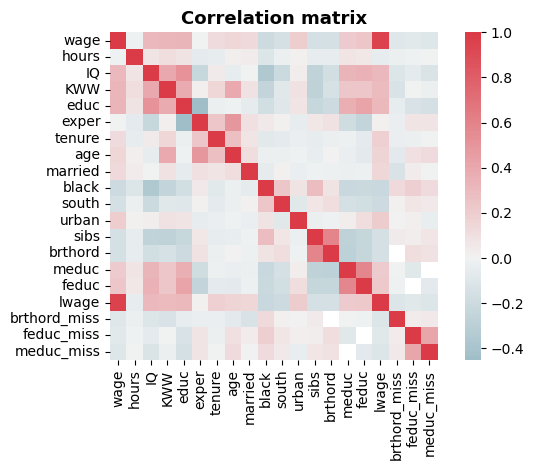

In [150]:
fig,ax = plt.subplots()
cmap = sns.diverging_palette (220,10, as_cmap = True)
sns.heatmap(data_test[data_test.columns].corr(), vmax =1, center =0, square =True, ax=ax, cmap =cmap)
ax.set_title('Correlation matrix', fontweight = 'bold', fontsize= 13)
plt.tight_layout()

In [151]:
data = data.drop(columns = 'feduc_miss')
data = data.drop(columns = 'meduc_miss')
data = data.drop(columns = 'brthord_miss')
data.describe()

wage       hours          IQ         KWW        educ  \
count   916.000000  916.000000  916.000000  916.000000  916.000000   
mean    959.967249   43.968341  101.552402   35.897380   13.492358   
std     406.573130    7.259144   14.853326    7.580847    2.198595   
min     115.000000   20.000000   54.000000   12.000000    9.000000   
25%     670.000000   40.000000   92.000000   31.000000   12.000000   
50%     907.500000   40.000000  102.000000   37.000000   12.000000   
75%    1161.000000   48.000000  112.000000   41.000000   16.000000   
max    3078.000000   80.000000  145.000000   56.000000   18.000000   

            exper      tenure         age     married       black       south  \
count  916.000000  916.000000  916.000000  916.000000  916.000000  916.000000   
mean    11.532751    7.169214   33.081878    0.893013    0.118996    0.336245   
std      4.381783    5.036997    3.103824    0.309265    0.323960    0.472682   
min      1.000000    0.000000   28.000000    0.000000    0.000000    0.000000   
25%      8.000000    3.000000   30.000000    1.000000    0.000000    0.000000   
50%     11.000000    7.000000   33.000000    1.000000    0.000000    0.000000   
75%     15.000000   11.000000   36.000000    1.000000    0.000000    1.000000   
max     23.000000   22.000000   38.000000    1.000000    1.000000    1.000000   

            urban        sibs     brthord       meduc       feduc       lwage  
count  916.000000  916.000000  836.000000  842.000000  731.000000  916.000000  
mean     0.720524    2.898472    2.259569   10.697150   10.209302    6.780388  
std      0.448987    2.260025    1.565601    2.848905    3.306900    0.423159  
min      0.000000    0.000000    1.000000    0.000000    0.000000    4.744932  
25%      0.000000    1.000000    1.000000    8.000000    8.000000    6.507277  
50%      1.000000    2.000000    2.000000   12.000000   10.000000    6.810692  
75%      1.000000    4.000000    3.000000   12.000000   12.000000    7.057037  
max      1.000000   14.000000   10.000000   18.000000   18.000000    8.032035

In [152]:
data_cl = data.dropna()
data_cl.describe()

wage       hours          IQ         KWW        educ  \
count   655.000000  655.000000  655.000000  655.000000  655.000000   
mean    988.340458   44.080916  102.534351   36.222901   13.691603   
std     407.903098    7.164164   14.690017    7.558685    2.231175   
min     115.000000   25.000000   54.000000   13.000000    9.000000   
25%     699.000000   40.000000   94.000000   32.000000   12.000000   
50%     935.000000   40.000000  104.000000   37.000000   13.000000   
75%    1200.000000   48.000000  113.000000   41.500000   16.000000   
max    3078.000000   80.000000  145.000000   56.000000   18.000000   

            exper      tenure         age     married       black       south  \
count  655.000000  655.000000  655.000000  655.000000  655.000000  655.000000   
mean    11.377099    7.157252   32.972519    0.900763    0.077863    0.320611   
std      4.255570    5.009594    3.064921    0.299208    0.268160    0.467068   
min      1.000000    0.000000   28.000000    0.000000    0.000000    0.000000   
25%      8.000000    2.500000   30.000000    1.000000    0.000000    0.000000   
50%     11.000000    7.000000   33.000000    1.000000    0.000000    0.000000   
75%     15.000000   11.000000   36.000000    1.000000    0.000000    1.000000   
max     22.000000   22.000000   38.000000    1.000000    1.000000    1.000000   

            urban        sibs     brthord       meduc       feduc       lwage  
count  655.000000  655.000000  655.000000  655.000000  655.000000  655.000000  
mean     0.717557    2.830534    2.166412   10.824427   10.264122    6.813621  
std      0.450532    2.230656    1.468768    2.829186    3.290545    0.413540  
min      0.000000    0.000000    1.000000    0.000000    0.000000    4.744932  
25%      0.000000    1.000000    1.000000    9.000000    8.000000    6.549650  
50%      1.000000    2.000000    2.000000   12.000000   10.000000    6.840547  
75%      1.000000    4.000000    3.000000   12.000000   12.000000    7.090077  
max      1.000000   14.000000   10.000000   18.000000   18.000000    8.032035

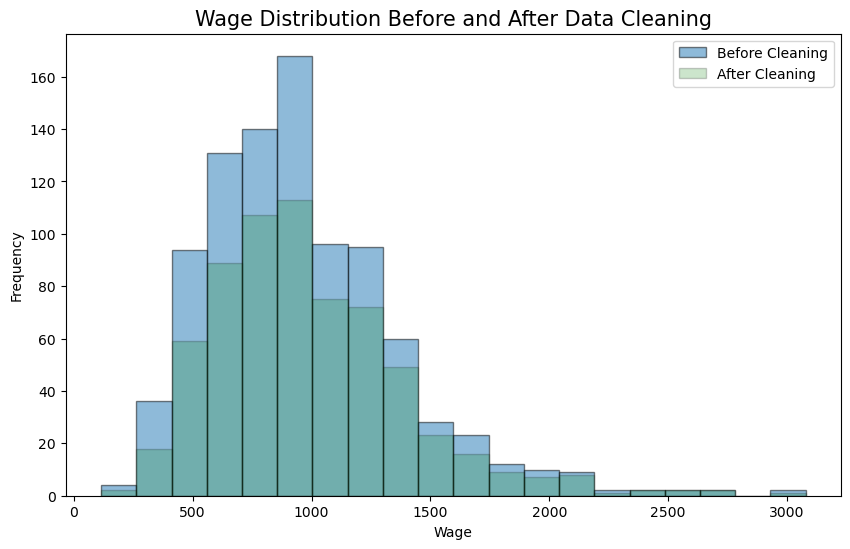

In [153]:
plt.figure(figsize=(10, 6))
plt.hist(data['wage'], bins=20, label='Before Cleaning', alpha=0.5, edgecolor = 'black')
plt.hist(data_cl['wage'], bins=20, label='After Cleaning', color='green', alpha=0.2, edgecolor = 'black')

# Adding title and legend
plt.title("Wage Distribution Before and After Data Cleaning", size = 15)
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.legend()

Another method is deleting the rows with missing data. One concern with this method is there can be a relationship between the missing data and the remaining variables ( (Lodder, 2016). Moreover, when all the rows with the missing data are removed, roughly 30% of the dataset is gone. To check the first concerns, three new binary variables are added (these variables are only used in this section of the report, they won’t be discussed further): brthord_miss, feduc_miss and meduc_miss. These variables are equal to one when there is a missing value and equal to 0 otherwise. From the correlation matrix, all three variables have a very low correlation to the other variables (below 0.3 (Calkins, 2005)). Furthermore, when comparing the distribution of the dependent variable in this report (wage) before and after removing the rows,  the wage distribution after removing the rows is similar to the wage distribution before removing the rows but with a lower count (as there is fewer data). Therefore, whether the data of brhord, meduc and feduc is missing is independent of other variables. For the second concern, preserving the integrity of data is crucial, hence although 30% of the available data is removed, this helps ensure that the analysis is conducted on a complete dataset without introducing bias through imputation methods. Moreover, even when the data are removed, the dataset still has 655 rows which is a fairly large sample. 

To build the model based on the purpose of this report, the dataset will be split into training data and testing data.

In [154]:
state=2622368160 # randomise the split between trainning and testing data

train = data_cl.sample(frac=0.8, random_state=state)
test = data_cl[data_cl.index.isin(train.index)==False].copy() # Only for prediction

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [155]:
train.describe()

wage       hours          IQ         KWW        educ  \
count   524.000000  524.000000  524.000000  524.000000  524.000000   
mean    991.618321   44.232824  102.368321   36.068702   13.681298   
std     416.010419    7.018358   14.623243    7.675484    2.282939   
min     115.000000   25.000000   54.000000   13.000000    9.000000   
25%     690.500000   40.000000   94.000000   31.000000   12.000000   
50%     937.500000   40.000000  104.000000   37.000000   13.000000   
75%    1200.000000   48.000000  113.000000   41.250000   16.000000   
max    3078.000000   75.000000  134.000000   56.000000   18.000000   

            exper      tenure         age     married       black       south  \
count  524.000000  524.000000  524.000000  524.000000  524.000000  524.000000   
mean    11.307252    7.133588   32.931298    0.904580    0.078244    0.320611   
std      4.284690    4.974245    3.056988    0.294075    0.268812    0.467157   
min      1.000000    0.000000   28.000000    0.000000    0.000000    0.000000   
25%      8.000000    3.000000   30.000000    1.000000    0.000000    0.000000   
50%     11.000000    7.000000   33.000000    1.000000    0.000000    0.000000   
75%     15.000000   11.000000   36.000000    1.000000    0.000000    1.000000   
max     22.000000   22.000000   38.000000    1.000000    1.000000    1.000000   

            urban        sibs     brthord       meduc       feduc       lwage  
count  524.000000  524.000000  524.000000  524.000000  524.000000  524.000000  
mean     0.719466    2.870229    2.192748   10.757634   10.322519    6.814935  
std      0.449690    2.236998    1.508125    2.904542    3.317055    0.418279  
min      0.000000    0.000000    1.000000    0.000000    0.000000    4.744932  
25%      0.000000    1.000000    1.000000    8.000000    8.000000    6.537409  
50%      1.000000    2.000000    2.000000   12.000000   11.000000    6.843217  
75%      1.000000    4.000000    3.000000   12.000000   12.000000    7.090077  
max      1.000000   14.000000   10.000000   18.000000   18.000000    8.032035

In [156]:
test.describe()

wage       hours          IQ         KWW        educ  \
count   131.000000  131.000000  131.000000  131.000000  131.000000   
mean    975.229008   43.473282  103.198473   36.839695   13.732824   
std     374.933606    7.718438   14.992521    7.066516    2.018470   
min     310.000000   27.000000   68.000000   18.000000   11.000000   
25%     734.000000   40.000000   94.500000   32.000000   12.000000   
50%     912.000000   40.000000  104.000000   37.000000   13.000000   
75%    1204.000000   45.000000  113.500000   41.500000   16.000000   
max    2137.000000   80.000000  145.000000   54.000000   18.000000   

            exper      tenure         age     married       black       south  \
count  131.000000  131.000000  131.000000  131.000000  131.000000  131.000000   
mean    11.656489    7.251908   33.137405    0.885496    0.076336    0.320611   
std      4.141295    5.166971    3.102761    0.319645    0.266554    0.468503   
min      1.000000    0.000000   28.000000    0.000000    0.000000    0.000000   
25%      9.000000    2.000000   30.500000    1.000000    0.000000    0.000000   
50%     12.000000    7.000000   32.000000    1.000000    0.000000    0.000000   
75%     14.500000   10.500000   36.000000    1.000000    0.000000    1.000000   
max     22.000000   21.000000   38.000000    1.000000    1.000000    1.000000   

            urban        sibs     brthord       meduc       feduc       lwage  
count  131.000000  131.000000  131.000000  131.000000  131.000000  131.000000  
mean     0.709924    2.671756    2.061069   11.091603   10.030534    6.808367  
std      0.455539    2.206434    1.299442    2.497538    3.183948    0.395523  
min      0.000000    0.000000    1.000000    1.000000    2.000000    5.736572  
25%      0.000000    1.000000    1.000000   10.000000    8.000000    6.598397  
50%      1.000000    2.000000    2.000000   12.000000   10.000000    6.815640  
75%      1.000000    3.000000    3.000000   12.000000   12.000000    7.093403  
max      1.000000   13.000000    7.000000   17.000000   18.000000    7.667158

There are 524 (80% of the cleaned dataset) rows in the training dataset and 131 (20% of the cleaned dataset) rows in the test dataset.

***

## IV. Exploratory Analysis of the Training Data

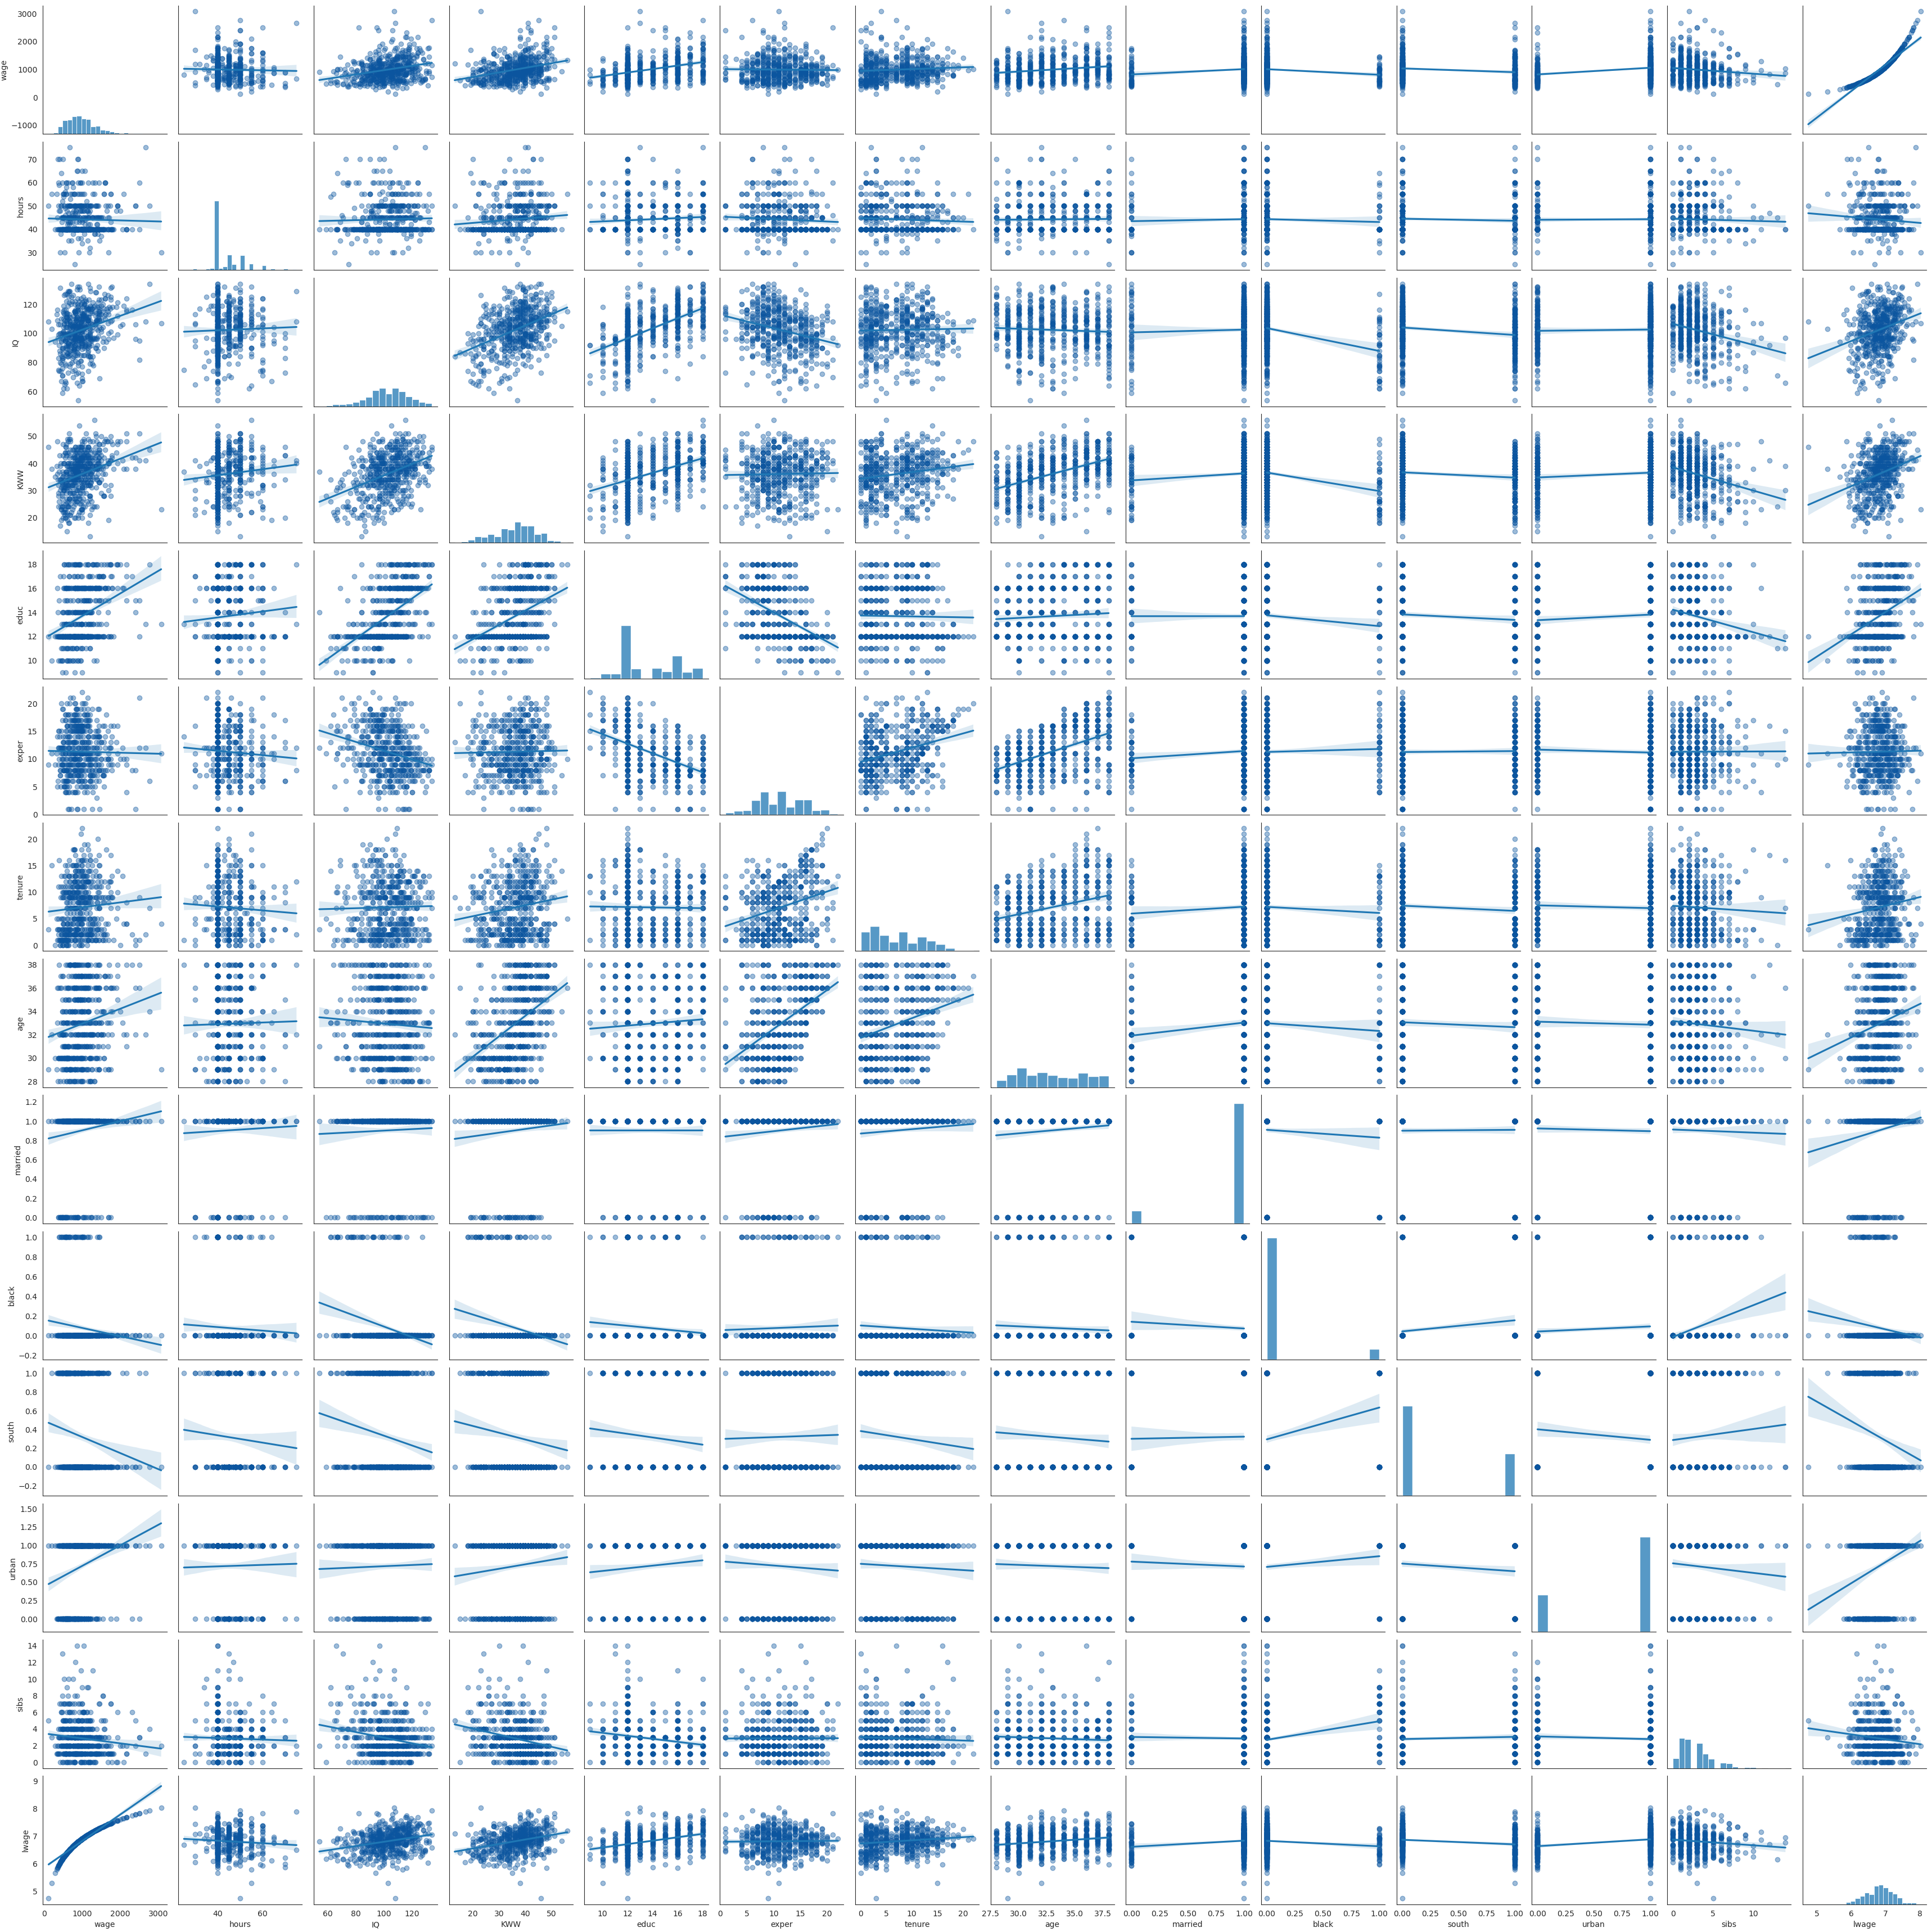

In [157]:
variables=['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'lwage']
with sns.axes_style('white'):
    g=sns.pairplot(train[variables], kind='reg',
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})

In [158]:
train.describe()

wage       hours          IQ         KWW        educ  \
count   524.000000  524.000000  524.000000  524.000000  524.000000   
mean    991.618321   44.232824  102.368321   36.068702   13.681298   
std     416.010419    7.018358   14.623243    7.675484    2.282939   
min     115.000000   25.000000   54.000000   13.000000    9.000000   
25%     690.500000   40.000000   94.000000   31.000000   12.000000   
50%     937.500000   40.000000  104.000000   37.000000   13.000000   
75%    1200.000000   48.000000  113.000000   41.250000   16.000000   
max    3078.000000   75.000000  134.000000   56.000000   18.000000   

            exper      tenure         age     married       black       south  \
count  524.000000  524.000000  524.000000  524.000000  524.000000  524.000000   
mean    11.307252    7.133588   32.931298    0.904580    0.078244    0.320611   
std      4.284690    4.974245    3.056988    0.294075    0.268812    0.467157   
min      1.000000    0.000000   28.000000    0.000000    0.000000    0.000000   
25%      8.000000    3.000000   30.000000    1.000000    0.000000    0.000000   
50%     11.000000    7.000000   33.000000    1.000000    0.000000    0.000000   
75%     15.000000   11.000000   36.000000    1.000000    0.000000    1.000000   
max     22.000000   22.000000   38.000000    1.000000    1.000000    1.000000   

            urban        sibs     brthord       meduc       feduc       lwage  
count  524.000000  524.000000  524.000000  524.000000  524.000000  524.000000  
mean     0.719466    2.870229    2.192748   10.757634   10.322519    6.814935  
std      0.449690    2.236998    1.508125    2.904542    3.317055    0.418279  
min      0.000000    0.000000    1.000000    0.000000    0.000000    4.744932  
25%      0.000000    1.000000    1.000000    8.000000    8.000000    6.537409  
50%      1.000000    2.000000    2.000000   12.000000   11.000000    6.843217  
75%      1.000000    4.000000    3.000000   12.000000   12.000000    7.090077  
max      1.000000   14.000000   10.000000   18.000000   18.000000    8.032035

In [159]:
train[train.columns].corr().round(2)

wage  hours    IQ   KWW  educ  exper  tenure   age  married  black  \
wage     1.00  -0.03  0.27  0.30  0.34  -0.02    0.08  0.17     0.13  -0.13   
hours   -0.03   1.00  0.03  0.10  0.08  -0.06   -0.05  0.02     0.04  -0.05   
IQ       0.27   0.03  1.00  0.40  0.54  -0.27    0.02 -0.06     0.04  -0.29   
KWW      0.30   0.10  0.40  1.00  0.40   0.02    0.16  0.44     0.10  -0.24   
educ     0.34   0.08  0.54  0.40  1.00  -0.46   -0.02  0.07     0.00  -0.11   
exper   -0.02  -0.06 -0.27  0.02 -0.46   1.00    0.30  0.47     0.09   0.03   
tenure   0.08  -0.05  0.02  0.16 -0.02   0.30    1.00  0.27     0.08  -0.06   
age      0.17   0.02 -0.06  0.44  0.07   0.47    0.27  1.00     0.11  -0.06   
married  0.13   0.04  0.04  0.10  0.00   0.09    0.08  0.11     1.00  -0.07   
black   -0.13  -0.05 -0.29 -0.24 -0.11   0.03   -0.06 -0.06    -0.07   1.00   
south   -0.15  -0.06 -0.16 -0.12 -0.09   0.02   -0.09 -0.06     0.01   0.20   
urban    0.26   0.02  0.03  0.10  0.09  -0.06   -0.05 -0.04    -0.04   0.09   
sibs    -0.11  -0.03 -0.22 -0.25 -0.18   0.00   -0.05 -0.06    -0.02   0.27   
brthord -0.14  -0.08 -0.18 -0.14 -0.17   0.04   -0.00 -0.03    -0.03   0.14   
meduc    0.24   0.06  0.32  0.27  0.36  -0.18    0.01  0.03    -0.01  -0.18   
feduc    0.25   0.04  0.35  0.24  0.45  -0.29   -0.06 -0.07    -0.03  -0.20   
lwage    0.95  -0.08  0.27  0.30  0.34   0.02    0.14  0.20     0.16  -0.13   

         south  urban  sibs  brthord  meduc  feduc  lwage  
wage     -0.15   0.26 -0.11    -0.14   0.24   0.25   0.95  
hours    -0.06   0.02 -0.03    -0.08   0.06   0.04  -0.08  
IQ       -0.16   0.03 -0.22    -0.18   0.32   0.35   0.27  
KWW      -0.12   0.10 -0.25    -0.14   0.27   0.24   0.30  
educ     -0.09   0.09 -0.18    -0.17   0.36   0.45   0.34  
exper     0.02  -0.06  0.00     0.04  -0.18  -0.29   0.02  
tenure   -0.09  -0.05 -0.05    -0.00   0.01  -0.06   0.14  
age      -0.06  -0.04 -0.06    -0.03   0.03  -0.07   0.20  
married   0.01  -0.04 -0.02    -0.03  -0.01  -0.03   0.16  
black     0.20   0.09  0.27     0.14  -0.18  -0.20  -0.13  
south     1.00  -0.11  0.06     0.15  -0.13  -0.14  -0.19  
urban    -0.11   1.00 -0.06    -0.05   0.04   0.09   0.27  
sibs      0.06  -0.06  1.00     0.58  -0.25  -0.18  -0.11  
brthord   0.15  -0.05  0.58     1.00  -0.27  -0.23  -0.15  
meduc    -0.13   0.04 -0.25    -0.27   1.00   0.59   0.24  
feduc    -0.14   0.09 -0.18    -0.23   0.59   1.00   0.23  
lwage    -0.19   0.27 -0.11    -0.15   0.24   0.23   1.00

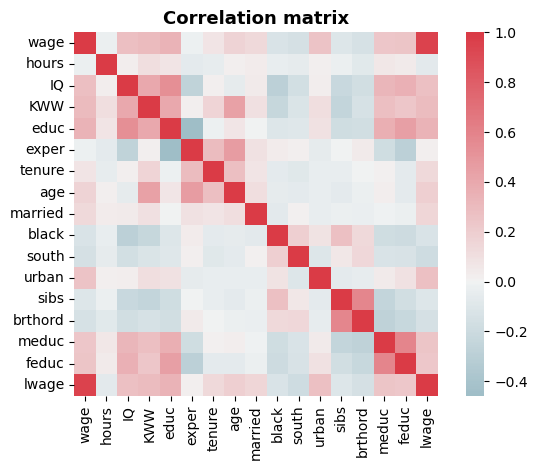

In [160]:
fig,ax = plt.subplots()
cmap = sns.diverging_palette (220,10, as_cmap = True)
sns.heatmap(train[train.columns].corr(), vmax =1, center =0, square =True, ax=ax, cmap =cmap)
ax.set_title('Correlation matrix', fontweight = 'bold', fontsize= 13)
plt.tight_layout()

In [161]:
stats.describe(train['wage']),train['wage'].median()

(DescribeResult(nobs=524, minmax=(115, 3078), mean=991.6183206106871, variance=173064.6685738473, skewness=1.208036030753104, kurtosis=2.5824005080270513),
 937.5)

<Axes: xlabel='wage', ylabel='Count'>

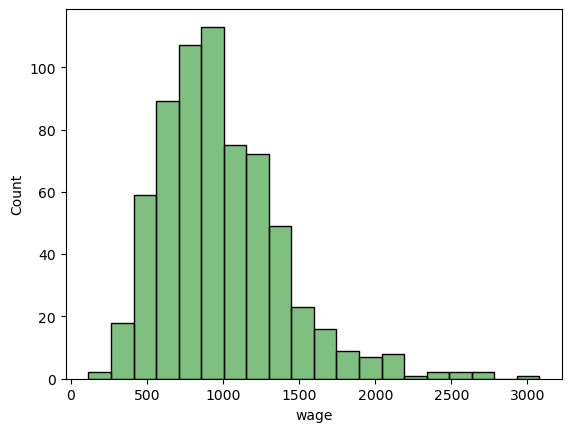

In [162]:
sns.histplot(data_cl['wage'], bins=20, label='After Cleaning', color='green', kde=False, alpha=0.5)

<Axes: >

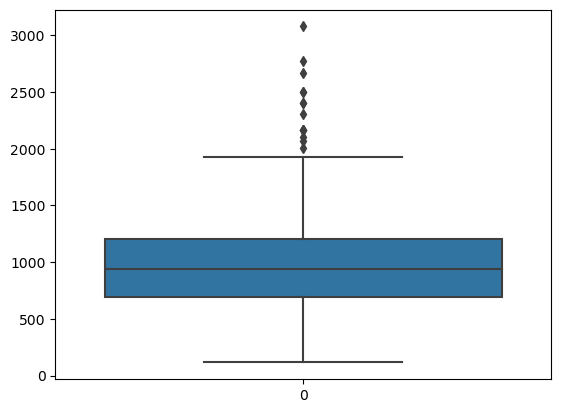

In [163]:
sns.boxplot(train['wage'])

Wages have a strong right-skewed distributionn with a long fat tail with several highly extreme outliers, up to a maximum of 3078/month. The sample mean price is 991.6 while median wage is 937.5.

In [164]:
stats.describe(train['educ']),train['educ'].median()

(DescribeResult(nobs=524, minmax=(9, 18), mean=13.681297709923664, variance=5.211810167413483, skewness=0.43657158804791085, kurtosis=-0.9705096101354016),
 13.0)

Text(0.5, 1.0, 'Education distribution after data cleaning')

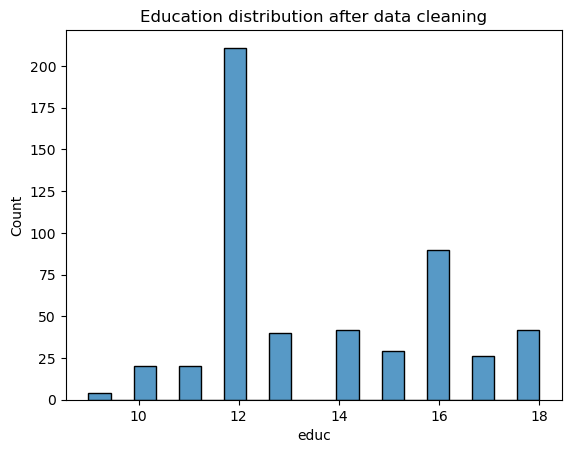

In [165]:
sns.histplot(train['educ'], bins = 20).set_title('Education distribution after data cleaning')

In [166]:
stats.describe(train['exper']),train['exper'].median()

(DescribeResult(nobs=524, minmax=(1, 22), mean=11.307251908396946, variance=18.35857063622962, skewness=0.06032881474598807, kurtosis=-0.516111738046729),
 11.0)

Text(0.5, 1.0, 'Experience after data cleaning')

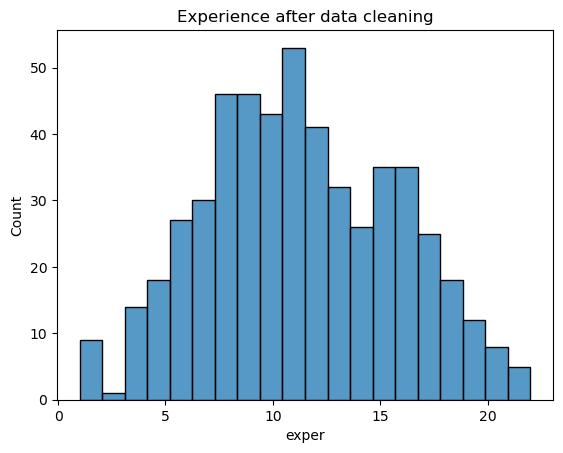

In [167]:
sns.histplot(train['exper'], bins = 20).set_title('Experience after data cleaning')

Years of experience is apporximately symmetric following a normal distribution with skewness of 0.06 and a maximum value of 22 years. The sample mean of experience is 11 years 3 months, while the median is 11 years and a standard deviation is $\sqrt{18.35}$ years.

Text(0.5, 1.0, 'Average Education vs Wage')

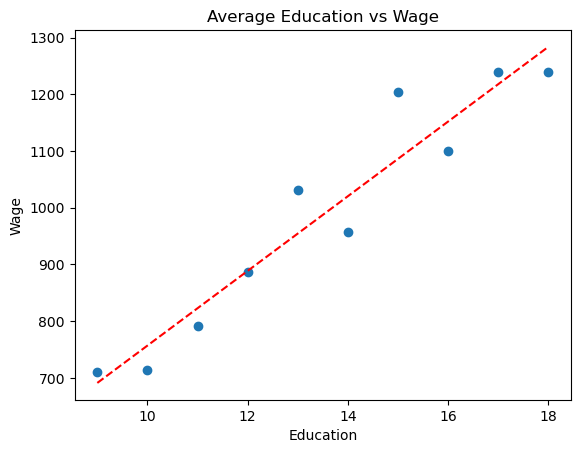

In [168]:
average_wage_by_education = train.groupby('educ')['wage'].mean().reset_index()
plt.scatter(average_wage_by_education['educ'], average_wage_by_education['wage'])
z = np.polyfit(average_wage_by_education['educ'], average_wage_by_education['wage'], 1)
p = np.poly1d(z)
plt.plot(average_wage_by_education['educ'],p(average_wage_by_education['educ']),"r--")
plt.xlabel('Education')
plt.ylabel('Wage')
plt.title('Average Education vs Wage')

According to the graph, there is a clear positive relationship, between average years of education and wage indicating that as education increases so does wage.

Text(0.5, 1.0, 'Average Experience vs Wage')

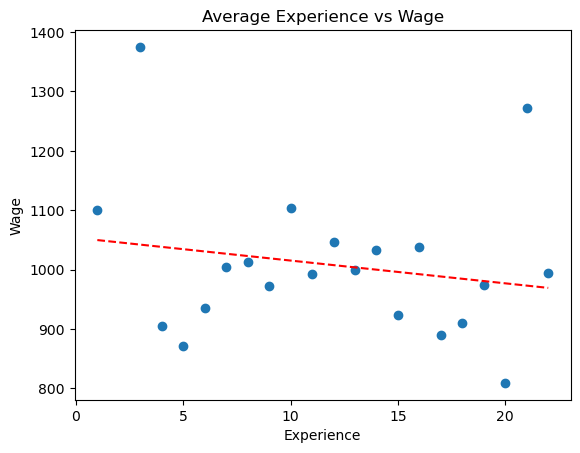

In [169]:
average_wage_by_experience = train.groupby('exper')['wage'].mean().reset_index()
plt.scatter(average_wage_by_experience['exper'], average_wage_by_experience['wage'])
z = np.polyfit(average_wage_by_experience['exper'], average_wage_by_experience['wage'], 1)
p = np.poly1d(z)
plt.plot(average_wage_by_experience['exper'],p(average_wage_by_experience['exper']),"r--")
plt.xlabel('Experience')
plt.ylabel('Wage')
plt.title('Average Experience vs Wage')

In contrast, the relationship between experience and wage demonstrates as slightly negative, suggesting other factors may be involved.

***

## V. Relationship between wage, educ, and exper

In [170]:
formula = 'wage ~ educ + exper'
reg = smf.ols(formula=formula, data=train).fit()
resid = reg.resid
fit = reg.fittedvalues
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     42.71
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           6.68e-18
Time:                        20:25:36   Log-Likelihood:                -3863.3
No. Observations:                 524   AIC:                             7733.
Df Residuals:                     521   BIC:                             7745.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -253.0079    144.936     -1.746      0.081    -537.738      31.723
educ          76.8569      8.325      9.232      0.000      60.502      93.211
exper         17.0797      4.436      3.851      0.000       8.366      25.794
==============================================================================
Omnibus:                      135.524   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.594
Skew:                           1.239   Prob(JB):                     1.53e-85
Kurtosis:                       6.428   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
#SER, R^2, adj_R^2
reg.mse_resid**0.5, reg.rsquared, reg.rsquared_adj

(386.3403608143095, 0.14085239936601646, 0.13755432796243106)

           wage      educ     exper
wage   1.000000  0.341178 -0.017311
educ   0.341178  1.000000 -0.458126
exper -0.017311 -0.458126  1.000000


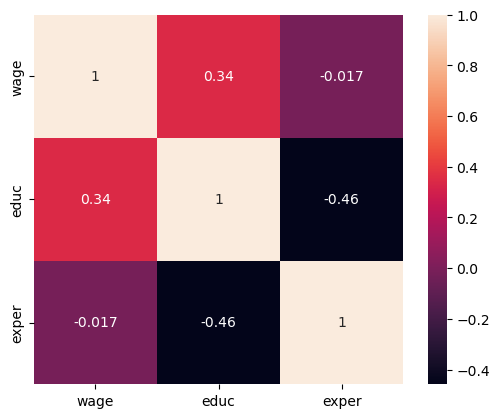

In [172]:
selected_data = train[['wage', 'educ', 'exper']]
corr_matrix = selected_data.corr()

print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, square=True)
plt.show()

Text(0.5, 1.0, 'Residual Plot')

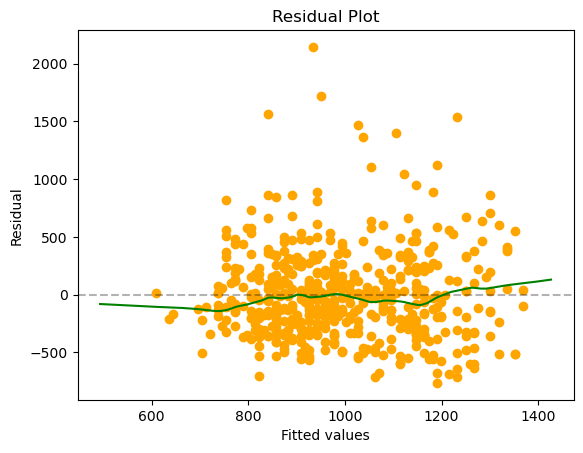

In [173]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(fit,resid, color='orange')
z = lowess(resid, fit_ovb, frac=1./5)
plt.axhline(color='Black', alpha=0.3, linestyle='--')
plt.plot(z[:,0],z[:,1],'green')
plt.xlabel('Fitted values')
plt.ylabel('Residual')
plt.title('Residual Plot')

Text(0.5, 0, 'Wage ($)')

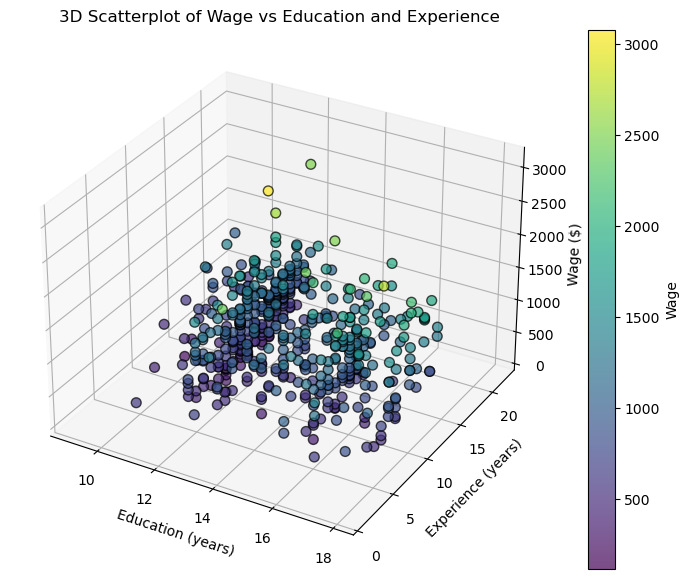

In [174]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(train['educ'], train['exper'], train['wage'], c=train['wage'], cmap='viridis', s=50, alpha=0.7, edgecolor='k')

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label('Wage')

# Add titles and labels
ax.set_title('3D Scatterplot of Wage vs Education and Experience')
ax.set_xlabel('Education (years)')
ax.set_ylabel('Experience (years)')
ax.set_zlabel('Wage ($)')

Based on the regression analysis conducted on the dataset, the relationship between wage, education, and experience appears to be substantial. The 3D scatterplot visually demonstrates that higher levels of education and experience tend to correlate with higher wages, which aligns with general theories of human capital. This is further supported by the correlation matrix, which shows positive correlations between wage and both education and experience.

The Ordinary Least Squares (OLS) regression model provides a detailed statistical view of this relationship. The model summary indicates that both education and experience are significant predictors of wage, with positive coefficients suggesting that increases in either education or experience lead to higher wages. The R-squared value, which measures the proportion of the variance in the dependent variable (wage) explained by the independent variables (education and experience), gives an indication of the model’s fit. A high R-squared value would imply that the model explains a significant portion of the variability in wages.

To ensure the validity of the regression model, several key assumptions were made. The linearity assumption is visually supported by the scatterplot, suggesting a roughly linear relationship between the variables. Independence of observations is assumed to be met given the design of the data collection. Homoscedasticity, or constant variance of residuals, needs to be checked using the residuals vs. fitted values plot and the Breusch-Pagan test; any deviation might suggest heteroscedasticity, which could affect the reliability of the model. The normality of residuals, ensures that the residuals are normally distributed, which is important for hypothesis testing. Lastly, multicollinearity is assessed through the Variance Inflation Factor (VIF); high VIF values would indicate that the predictors are too highly correlated, which could distort the results.

Overall, if these assumptions hold true, the model effectively captures the relationship between wage, education, and experience, providing insights into how these factors interact to influence earnings. If the R-squared value is reasonably high and the assumptions are met, the model fits the data well, suggesting that education and experience are strong predictors of wage in this dataset.

***

## VI. Omitted Variable Bias (OVB)

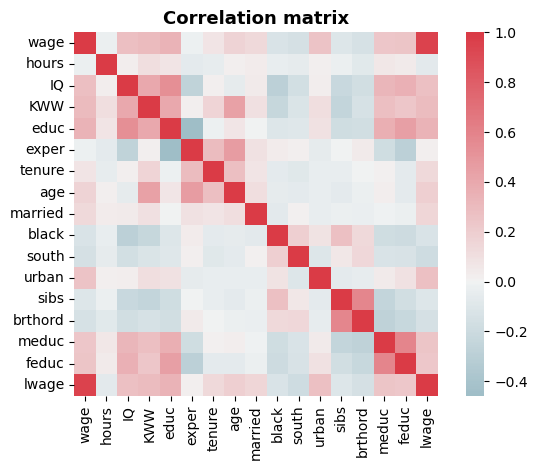

In [175]:
fig,ax = plt.subplots()
cmap = sns.diverging_palette (220,10, as_cmap = True)
sns.heatmap(train[train.columns].corr(), vmax =1, center =0, square =True, ax=ax, cmap =cmap)
ax.set_title('Correlation matrix', fontweight = 'bold', fontsize= 13)
plt.tight_layout()

In [176]:
formula_ovb = 'wage ~ educ + exper + age + meduc + feduc + IQ + KWW'
reg_ovb = smf.ols(formula=formula_ovb, data=train).fit()
resid_ovb = reg_ovb.resid
fit_ovb = reg_ovb.fittedvalues
reg_ovb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     16.54
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           1.01e-19
Time:                        20:25:37   Log-Likelihood:                -3850.1
No. Observations:                 524   AIC:                             7716.
Df Residuals:                     516   BIC:                             7750.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -697.3386    234.048     -2.979      0.003   -1157.143    -237.534
educ          44.8677     10.486      4.279      0.000      24.266      65.469
exper         11.8715      5.270      2.252      0.025       1.517      22.226
age            8.6918      7.364      1.180      0.238      -5.775      23.159
meduc         10.3574      7.206      1.437      0.151      -3.800      24.515
feduc          9.9800      6.583      1.516      0.130      -2.953      22.913
IQ             2.3686      1.444      1.641      0.101      -0.467       5.204
KWW            5.4822      2.818      1.945      0.052      -0.055      11.019
==============================================================================
Omnibus:                      134.916   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              416.749
Skew:                           1.206   Prob(JB):                     3.19e-91
Kurtosis:                       6.643   Cond. No.                     1.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [177]:
#SER, R^2, adj_R^2
reg_ovb.mse_resid**0.5, reg_ovb.rsquared, reg_ovb.rsquared_adj

(378.4967373716827, 0.1832975127210963, 0.17221821541304916)

Text(0.5, 1.0, 'Residual Plot')

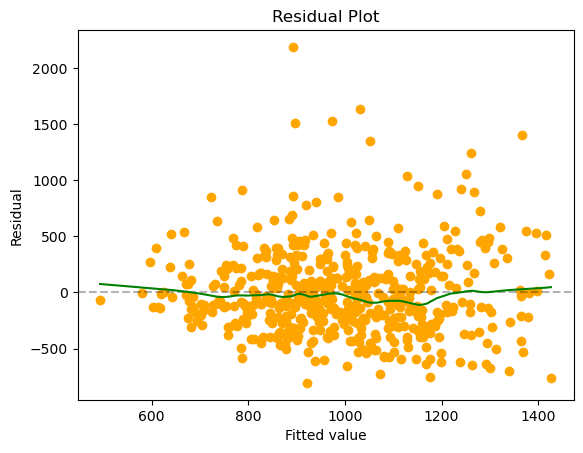

In [178]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(fit_ovb,resid_ovb, color='orange')
z_ovb = lowess(resid_ovb, fit_ovb, frac=1./5)
plt.axhline(color='Black', alpha=0.3, linestyle='--')
plt.plot(z_ovb[:,0],z_ovb[:,1],'green')
plt.xlabel('Fitted value')
plt.ylabel('Residual')
plt.title('Residual Plot')

The correlation heat-map illustrates some strong positive or negative correlations between variables in this dataset.

IQ, meduc, feduc, age, KWW seem likely to be the determinants of the dependent variable wage based on the correlation matrix (Figure 8). Further, IQ has a strong positive correlation with educ, meduc has a moderate positive correlation with educ, feduc has a moderate positive correlation with educ. Age has a strong positive correlation with exper, KWW has a moderate positive correlation with exper. These make sense and would be expected. 

IQ: People who have higher IQ scores usually are more intelligent and are more likely to get higher education levels. And at the same time get better performance in work thus they are more likely to get a high wage and more years of education. Thus when IQ correlates with both educ and wage, if we omit it from the regression model it will cause the effect of educ on wage to be overstated which causes OVB.

Meduc/Feduc: Parents with higher education level can provide kids with more educational opportunities which can affect the children’s wage. If meduc and feduc are omitted, it may cause OVB where the effect of meduc and feduc on wage will be erroneously attributed to educ.

People who are older usually have more working experience and higher salary. If age is omitted, it may cause its effect on wage erroneously attributed to exper.

KWW can be correlated to both age and exper. People who are older or have more experience usually know better about the world working knowledge. If we omit KWW from the regression model it may cause OVB. The regression model 

In the model with only educ and exper we can find out the SER value is high (386.3404) which means that the model’s prediction is not that good, there may be omitted variable bias(OVB). It shows that some important predictors are omitted resulting in a poor fit. After we add the potential omitted variables into the model IQ/KWW/feduc/meduc the SER has decreased to 378.4967 which shows the fit of the model get improved.


The initial model has an R2 of 0.126, adjusted R2 of 0.123 and SER of 389.97. The model with more variables (OVB) added has R2= 0.1832, adjusted R2 = 0.1722 and SER = 378.4967. 

This indicates that the initial model captures approximately 12% of the variation in wage with a prediction error of \\$389.97. The reduced model accounts for 18% of the variation in wage with a prediction error of \\$378.50. Evidently, both models are not the best fit for this data due to the low R2 values. This weak fit can indicate that a more complex model is required or that in terms of determining wages, there can be a multitude of explanatory variables that interact and cause variance in the monthly wages individuals in the United States earn.
However, the reduced model that utilises what we deemed as the important explanatory variables alone has captured 6% more of the variation in wage and reduced the prediction error for the monthly earnings by \\$11. Furthermore, the standard deviation of wage between both models has decreased from \\$416 to \\$389 indicating a better performance by the reduced model as there is a decreased spread and increased predictability of the variable wage.


***

## VII. Variable and Model Selection

In [179]:
def forward_selected(data, response, nominated = []):
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

def backward_selected(data, response, nominated = []):
    remaining = set(data.columns)
    remaining.remove(response)
    if nominated:
        print("you nominated variables %s" %nominated)
    nominated = set(nominated)
    remaining^=nominated
    formula = "{} ~ {} + 1".format(response,' + '.join(remaining | nominated))
    current_score = smf.ols(formula, data).fit().rsquared_adj
    print("adj_r2 if all variables included: %f" %current_score)
    best_new_score = current_score
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(remaining^{candidate}|nominated))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("deleting %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(remaining|nominated))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

### Model 1: Using forward selection for all variables (except lwage)

In [180]:
train.columns

Index(['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc', 'lwage'],
      dtype='object')

In [181]:
model_fs1 = forward_selected(train[['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc']], 'wage', nominated=['educ','exper'])

you nominated variable(s) ['educ', 'exper'], the adj_r2 is: 0.137554
adding urban increases adj_r2 from 0.137554 to 0.189171
adding married increases adj_r2 from 0.189171 to 0.204447
adding meduc increases adj_r2 from 0.204447 to 0.220094
adding KWW increases adj_r2 from 0.220094 to 0.228303
adding south increases adj_r2 from 0.228303 to 0.232708
adding hours increases adj_r2 from 0.232708 to 0.236351
adding IQ increases adj_r2 from 0.236351 to 0.238078
adding age increases adj_r2 from 0.238078 to 0.239606
adding feduc increases adj_r2 from 0.239606 to 0.240203
adding black increases adj_r2 from 0.240203 to 0.240418
final model is wage ~ educ + exper + urban + married + meduc + KWW + south + hours + IQ + age + feduc + black + 1, with adj_r2 of 0.240418


In [182]:
formula_mod1 = 'wage ~ educ + exper + urban + married + meduc + KWW + south + hours + IQ + age + feduc + black'
reg_mod1 = smf.ols(formula=formula_mod1, data=train).fit()
resid_mod1 = reg_mod1.resid
fit_mod1 = reg_mod1.fittedvalues
reg_mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     14.79
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           9.46e-27
Time:                        20:25:37   Log-Likelihood:                -3825.0
No. Observations:                 524   AIC:                             7676.
Df Residuals:                     511   BIC:                             7731.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -712.3244    257.573     -2.766      0.006   -1218.357    -206.292
educ          44.0995     10.143      4.348      0.000      24.173      64.026
exper         10.3140      5.062      2.038      0.042       0.370      20.258
urban        214.7654     36.305      5.916      0.000     143.439     286.092
married      170.8574     54.669      3.125      0.002      63.453     278.262
meduc         11.4493      6.921      1.654      0.099      -2.147      25.046
KWW            3.0844      2.757      1.119      0.264      -2.332       8.501
south        -54.7772     35.354     -1.549      0.122    -124.233      14.679
hours         -4.0397      2.284     -1.769      0.078      -8.527       0.448
IQ             2.1217      1.426      1.488      0.137      -0.679       4.923
age           10.7532      7.104      1.514      0.131      -3.204      24.710
feduc          6.8615      6.354      1.080      0.281      -5.623      19.346
black        -68.8957     64.399     -1.070      0.285    -195.415      57.623
==============================================================================
Omnibus:                      157.435   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              584.777
Skew:                           1.342   Prob(JB):                    1.04e-127
Kurtosis:                       7.425   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [183]:
#SER, R^2, adj_R^2
reg_mod1.mse_resid**0.5, reg_mod1.rsquared, reg_mod1.rsquared_adj

(362.56980069389397, 0.25784596682881655, 0.24041769207724273)

### Model 2: Using backward selection for all variables (except lwage)

In [184]:
model_bs2 = backward_selected(train[['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc']], 'wage', nominated=['educ','exper'])

you nominated variables ['educ', 'exper']
adj_r2 if all variables included: 0.239790
deleting tenure increases adj_r2 from 0.239790 to 0.241155
deleting feduc increases adj_r2 from 0.241155 to 0.241285
final model is wage ~ age + brthord + married + black + educ + KWW + meduc + exper + urban + hours + sibs + south + IQ + 1, with adj_r2 of 0.241285


In [185]:
formula_mod2 = 'wage ~ educ + exper + sibs + south + urban + KWW + black + married + IQ + age + hours + brthord + meduc'
reg_mod2 = smf.ols(formula=formula_mod2, data=train).fit()
resid_mod2 = reg_mod2.resid
fit_mod2 = reg_mod2.fittedvalues
reg_mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     13.79
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           1.78e-26
Time:                        20:25:38   Log-Likelihood:                -3824.2
No. Observations:                 524   AIC:                             7676.
Df Residuals:                     510   BIC:                             7736.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -690.1514    263.701     -2.617      0.009   -1208.225    -172.077
educ          46.5041      9.951      4.673      0.000      26.954      66.054
exper         10.4759      5.073      2.065      0.039       0.509      20.443
sibs          13.9117      9.180      1.515      0.130      -4.124      31.948
south        -48.4320     35.657     -1.358      0.175    -118.484      21.620
urban        219.4242     36.304      6.044      0.000     148.100     290.748
KWW            3.6509      2.774      1.316      0.189      -1.799       9.101
black        -93.2636     65.573     -1.422      0.156    -222.091      35.563
married      166.9183     54.663      3.054      0.002      59.526     274.311
IQ             2.1787      1.426      1.528      0.127      -0.622       4.979
age            9.7030      7.084      1.370      0.171      -4.214      23.620
hours         -4.3204      2.287     -1.889      0.059      -8.814       0.173
brthord      -18.5109     13.280     -1.394      0.164     -44.602       7.580
meduc         14.7397      6.162      2.392      0.017       2.633      26.847
==============================================================================
Omnibus:                      160.265   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              615.611
Skew:                           1.355   Prob(JB):                    2.10e-134
Kurtosis:                       7.566   Cond. No.                     2.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [186]:
#SER, R^2, adj_R^2
reg_mod2.mse_resid**0.5, reg_mod2.rsquared, reg_mod2.rsquared_adj

(362.3628358567149, 0.26014370757700145, 0.24128462561327801)

### Model 3: Using forward selection for all the variables (except wage, lwage will be used instead)

Based on the boxplot of wage, there are some outliers, so log(wage) can help minimised the influence of the outliers.

In [187]:
model_fs3 = forward_selected(train[['lwage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc']], 'lwage', nominated=['educ','exper'])

you nominated variable(s) ['educ', 'exper'], the adj_r2 is: 0.148459
adding urban increases adj_r2 from 0.148459 to 0.204363
adding married increases adj_r2 from 0.204363 to 0.224880
adding meduc increases adj_r2 from 0.224880 to 0.241744
adding south increases adj_r2 from 0.241744 to 0.253336
adding hours increases adj_r2 from 0.253336 to 0.265207
adding KWW increases adj_r2 from 0.265207 to 0.271087
adding tenure increases adj_r2 from 0.271087 to 0.273322
adding IQ increases adj_r2 from 0.273322 to 0.274587
adding age increases adj_r2 from 0.274587 to 0.276323
adding black increases adj_r2 from 0.276323 to 0.276464
final model is lwage ~ educ + exper + urban + married + meduc + south + hours + KWW + tenure + IQ + age + black + 1, with adj_r2 of 0.276464


In [188]:
formula_mod3 = 'lwage ~ educ + exper + urban + married + meduc + south + hours + KWW + tenure + IQ + age + black'
reg_mod3 = smf.ols(formula=formula_mod3, data=train).fit()
resid_mod3 = reg_mod3.resid
fit_mod3 = reg_mod3.fittedvalues
reg_mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     17.65
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           7.16e-32
Time:                        20:25:38   Log-Likelihood:                -195.44
No. Observations:                 524   AIC:                             416.9
Df Residuals:                     511   BIC:                             472.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1635      0.252     20.454      0.000       4.668       5.660
educ           0.0494      0.010      5.063      0.000       0.030       0.069
exper          0.0119      0.005      2.334      0.020       0.002       0.022
urban          0.2278      0.036      6.397      0.000       0.158       0.298
married        0.2004      0.054      3.733      0.000       0.095       0.306
meduc          0.0161      0.006      2.716      0.007       0.004       0.028
south         -0.0850      0.035     -2.443      0.015      -0.153      -0.017
hours         -0.0069      0.002     -3.093      0.002      -0.011      -0.003
KWW            0.0021      0.003      0.758      0.449      -0.003       0.007
tenure         0.0049      0.003      1.466      0.143      -0.002       0.012
IQ             0.0021      0.001      1.469      0.142      -0.001       0.005
age            0.0104      0.007      1.496      0.135      -0.003       0.024
black         -0.0660      0.063     -1.049      0.295      -0.190       0.058
==============================================================================
Omnibus:                       42.026   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.083
Skew:                          -0.267   Prob(JB):                     6.99e-33
Kurtosis:                       5.549   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cannot use the normal SER, R2 and adj R2 to compare with other models that used wage (instead of lwage)

In [189]:
n = 524
p = 12
var_wage_train = 416.010419**2

eres3 = np.exp(resid_mod3)

#duan
fp3 = sum(eres3)/n
TS_mod3 = np.exp(fit_mod3) * fp3

#normal
fp33 = np.exp(reg_mod3.mse_resid/2)
TS_mod33 = np.exp(fit_mod3) * fp33

In [190]:
# SER, R2, and adj-R2 for mod3 (Duan)
res_mod3 = train['wage']-TS_mod3
np.sqrt(sum(res_mod3**2)/(n-p-1)), 1 - sum(res_mod3**2)/((n-1)*var_wage_train), 1 - sum(res_mod3**2)/(n-p-1)/var_wage_train

(363.34446292966527, 0.25467122490455196, 0.23716839652657673)

In [191]:
# SER, R2, and adj-R2 for mod3 (normal)
res_mod33 = train['wage']-TS_mod33
np.sqrt(sum(res_mod33**2)/(n-p-1)), 1 - sum(res_mod33**2)/((n-1)*var_wage_train), 1 - sum(res_mod33**2)/(n-p-1)/var_wage_train

(363.3719411367511, 0.25455848850734253, 0.2370530126992958)

### Model 4: Using backward selection for all the variables (except wage, lwage will be used instead)

In [192]:
model_bs4 = backward_selected(train[['lwage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc']], 'lwage', nominated=['educ','exper'])

you nominated variables ['educ', 'exper']
adj_r2 if all variables included: 0.277953
deleting feduc increases adj_r2 from 0.277953 to 0.278930
deleting KWW increases adj_r2 from 0.278930 to 0.279080
final model is lwage ~ age + brthord + tenure + married + black + educ + exper + meduc + urban + hours + sibs + south + IQ + 1, with adj_r2 of 0.279080


In [193]:
formula_mod4 = 'lwage ~ educ + exper + sibs + south + urban + black + married + IQ + age + hours + brthord + meduc + tenure'
reg_mod4 = smf.ols(formula=formula_mod4, data=train).fit()
resid_mod4 = reg_mod4.resid
fit_mod4 = reg_mod4.fittedvalues
reg_mod4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     16.57
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           8.00e-32
Time:                        20:25:38   Log-Likelihood:                -193.97
No. Observations:                 524   AIC:                             415.9
Df Residuals:                     510   BIC:                             475.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1004      0.248     20.605      0.000       4.614       5.587
educ           0.0508      0.010      5.256      0.000       0.032       0.070
exper          0.0121      0.005      2.373      0.018       0.002       0.022
sibs           0.0145      0.009      1.618      0.106      -0.003       0.032
south         -0.0751      0.035     -2.142      0.033      -0.144      -0.006
urban          0.2349      0.035      6.652      0.000       0.166       0.304
black         -0.0915      0.064     -1.431      0.153      -0.217       0.034
married        0.1994      0.054      3.724      0.000       0.094       0.305
IQ             0.0024      0.001      1.808      0.071      -0.000       0.005
age            0.0128      0.006      2.031      0.043       0.000       0.025
hours         -0.0070      0.002     -3.132      0.002      -0.011      -0.003
brthord       -0.0213      0.013     -1.638      0.102      -0.047       0.004
meduc          0.0160      0.006      2.666      0.008       0.004       0.028
tenure         0.0053      0.003      1.571      0.117      -0.001       0.012
==============================================================================
Omnibus:                       37.203   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.594
Skew:                          -0.225   Prob(JB):                     1.45e-27
Kurtosis:                       5.336   Cond. No.                     1.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [194]:
n = 524
p = 13
var_wage_train = 416.010419**2

eres4 = np.exp(resid_mod4)

#duan
fp4 = sum(eres4)/n
TS_mod4 = np.exp(fit_mod4) * fp4

#normal
fp44 = np.exp(reg_mod4.mse_resid/2)
TS_mod44 = np.exp(fit_mod4) * fp44

In [195]:
# SER, R2, and adj-R2 for mod4 (Duan)
res_mod4 = train['wage']-TS_mod4
np.sqrt(sum(res_mod4**2)/(n-p-1)), 1 - sum(res_mod4**2)/((n-1)*var_wage_train), 1 - sum(res_mod4**2)/(n-p-1)/var_wage_train

(363.2773734125488, 0.2564044714973822, 0.23745007567280574)

In [196]:
# SER, R2, and adj-R2 for mod4 (normal)
res_mod44 = train['wage']-TS_mod44
np.sqrt(sum(res_mod44**2)/(n-p-1)), 1 - sum(res_mod44**2)/((n-1)*var_wage_train), 1 - sum(res_mod44**2)/(n-p-1)/var_wage_train

(363.3060046100504, 0.25628725599777735, 0.23732987232713254)

Compare model 1 to model 3 and model 2 to model 4, the lwage does not contribute to improving the adjusted $R^2$. Hence, we decided to focus on using wage instead of lwage for the following models.

### Model 5: Using forward selection with $IQ^2$ and $KWW^2$ added to the variables

Based on the graph between IQ and wage, and KWW and wage, they're showing a potential quadratic relationship.

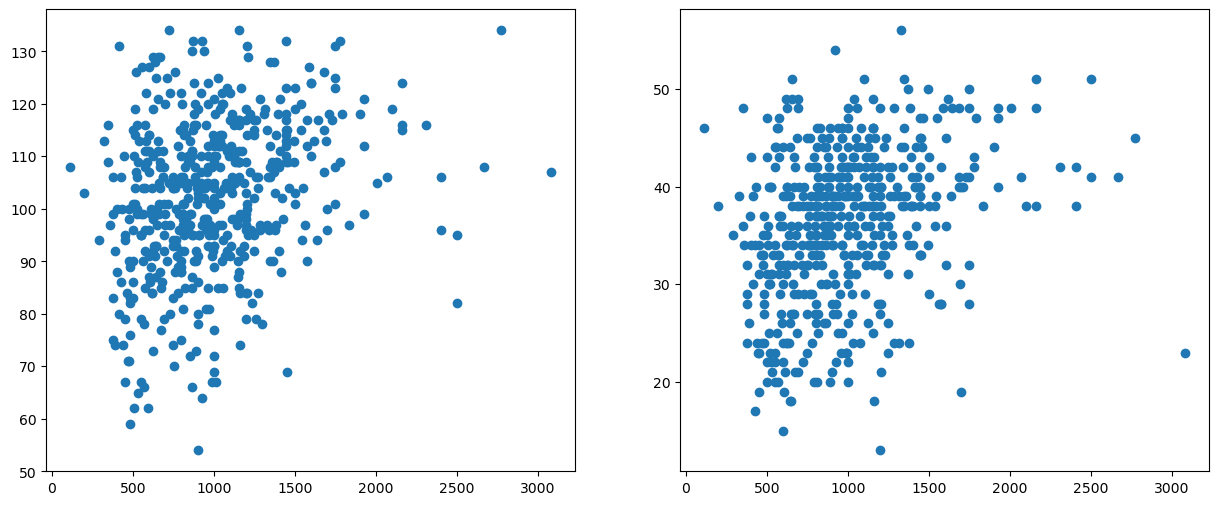

In [197]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
plt.scatter(x = train['wage'], y =train['IQ'])
ax2 = fig.add_subplot(1,2,2)
plt.scatter(x = train['wage'], y =train['KWW'])

In [198]:
train['IQ_square'] = train['IQ'] * train['IQ']
train['KWW_square'] = train['KWW'] * train['KWW']

In [199]:
model_fs5 = forward_selected(train[['wage', 'hours', 'IQ_square', 'KWW_square', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc']], 'wage', nominated=['educ','exper'])

you nominated variable(s) ['educ', 'exper'], the adj_r2 is: 0.137554
adding urban increases adj_r2 from 0.137554 to 0.189171
adding KWW_square increases adj_r2 from 0.189171 to 0.206348
adding married increases adj_r2 from 0.206348 to 0.218736
adding meduc increases adj_r2 from 0.218736 to 0.230209
adding south increases adj_r2 from 0.230209 to 0.234402
adding hours increases adj_r2 from 0.234402 to 0.238287
adding IQ_square increases adj_r2 from 0.238287 to 0.240033
adding age increases adj_r2 from 0.240033 to 0.240922
adding black increases adj_r2 from 0.240922 to 0.241568
adding feduc increases adj_r2 from 0.241568 to 0.241733
final model is wage ~ educ + exper + urban + KWW_square + married + meduc + south + hours + IQ_square + age + black + feduc + 1, with adj_r2 of 0.241733


In [200]:
formula_mod5 = 'wage ~ educ + exper + urban + KWW_square + married + meduc + south + hours + IQ_square + age + black + feduc'
reg_mod5 = smf.ols(formula=formula_mod5, data=train).fit()
resid_mod5 = reg_mod5.resid
fit_mod5 = reg_mod5.fittedvalues
reg_mod5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     14.89
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           6.23e-27
Time:                        20:25:39   Log-Likelihood:                -3824.5
No. Observations:                 524   AIC:                             7675.
Df Residuals:                     511   BIC:                             7730.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -517.8155    250.132     -2.070      0.039   -1009.229     -26.402
educ          43.2393     10.195      4.241      0.000      23.210      63.268
exper         10.3845      5.057      2.054      0.041       0.449      20.320
urban        213.4151     36.276      5.883      0.000     142.146     284.684
KWW_square     0.0567      0.039      1.448      0.148      -0.020       0.134
married      171.3752     54.604      3.138      0.002      64.098     278.652
meduc         11.5497      6.902      1.673      0.095      -2.010      25.109
south        -54.0246     35.330     -1.529      0.127    -123.435      15.386
hours         -4.1311      2.284     -1.809      0.071      -8.618       0.356
IQ_square      0.0103      0.007      1.455      0.146      -0.004       0.024
age            9.6262      7.120      1.352      0.177      -4.362      23.615
black        -69.9994     63.908     -1.095      0.274    -195.554      55.555
feduc          6.6959      6.351      1.054      0.292      -5.782      19.173
==============================================================================
Omnibus:                      157.407   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              587.833
Skew:                           1.339   Prob(JB):                    2.26e-128
Kurtosis:                       7.444   Cond. No.                     1.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [201]:
#SER, R^2, adj_R^2
reg_mod5.mse_resid**0.5, reg_mod5.rsquared, reg_mod5.rsquared_adj

(362.25563226913573, 0.2591315694652103, 0.24173348499081215)

### Model 6: Using backward selection with $IQ^2$ and $KWW^2$ added to the variables

In [202]:
model_bs6 = backward_selected(train[['wage', 'hours', 'IQ_square', 'KWW_square', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc']], 'wage', nominated=['educ','exper'])

you nominated variables ['educ', 'exper']
adj_r2 if all variables included: 0.241238
deleting tenure increases adj_r2 from 0.241238 to 0.242604
deleting feduc increases adj_r2 from 0.242604 to 0.242811
final model is wage ~ age + brthord + married + black + educ + exper + meduc + IQ_square + hours + urban + south + sibs + KWW_square + 1, with adj_r2 of 0.242811


In [203]:
formula_mod6 = 'wage ~ educ + exper + sibs + IQ_square + south + KWW_square + urban + black + married + age + hours + brthord + meduc'
reg_mod6 = smf.ols(formula=formula_mod6, data=train).fit()
resid_mod6 = reg_mod6.resid
fit_mod6 = reg_mod6.fittedvalues
reg_mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     13.90
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           1.10e-26
Time:                        20:25:39   Log-Likelihood:                -3823.6
No. Observations:                 524   AIC:                             7675.
Df Residuals:                     510   BIC:                             7735.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -483.9581    254.680     -1.900      0.058    -984.310      16.394
educ          45.5764     10.012      4.552      0.000      25.907      65.246
exper         10.5715      5.069      2.086      0.038       0.614      20.529
sibs          14.1778      9.171      1.546      0.123      -3.839      32.194
IQ_square      0.0106      0.007      1.498      0.135      -0.003       0.024
south        -47.4422     35.635     -1.331      0.184    -117.451      22.567
KWW_square     0.0650      0.039      1.649      0.100      -0.012       0.142
urban        218.0819     36.268      6.013      0.000     146.829     289.335
black        -94.9325     65.143     -1.457      0.146    -222.914      33.049
married      167.4602     54.591      3.068      0.002      60.210     274.711
age            8.5565      7.100      1.205      0.229      -5.393      22.506
hours         -4.4173      2.287     -1.932      0.054      -8.910       0.075
brthord      -18.6654     13.263     -1.407      0.160     -44.723       7.392
meduc         14.7878      6.143      2.407      0.016       2.719      26.857
==============================================================================
Omnibus:                      160.225   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              618.813
Skew:                           1.353   Prob(JB):                    4.23e-135
Kurtosis:                       7.585   Cond. No.                     1.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [204]:
#SER, R^2, adj_R^2
reg_mod6.mse_resid**0.5, reg_mod6.rsquared, reg_mod6.rsquared_adj

(361.99825244480525, 0.26163173895650993, 0.24281058720442106)

### Model 7: Using forward selection with all variables (except KWW, IQ, lwage) and add the interaction term exper and age 

There's a potential interaction between experience and age on the monthly wage. People who are older are more likely to have more years of experience which might lead to higher monthly wage. Hence, the interaction term exper_age is added. 

In [205]:
train['exper_age'] = train['exper'] * train['age']
train.columns

Index(['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc', 'lwage', 'IQ_square', 'KWW_square', 'exper_age'],
      dtype='object')

In [206]:
model_fs7 = forward_selected(train[['wage', 'hours', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc', 'IQ_square', 'KWW_square',
        'exper_age']], 'wage', nominated=['educ','exper','age'])

you nominated variable(s) ['educ', 'exper', 'age'], the adj_r2 is: 0.141853
adding urban increases adj_r2 from 0.141853 to 0.195224
adding meduc increases adj_r2 from 0.195224 to 0.209995
adding married increases adj_r2 from 0.209995 to 0.224529
adding IQ_square increases adj_r2 from 0.224529 to 0.232952
adding south increases adj_r2 from 0.232952 to 0.235806
adding hours increases adj_r2 from 0.235806 to 0.238435
adding exper_age increases adj_r2 from 0.238435 to 0.241248
adding KWW_square increases adj_r2 from 0.241248 to 0.243202
adding feduc increases adj_r2 from 0.243202 to 0.243733
adding black increases adj_r2 from 0.243733 to 0.243845
final model is wage ~ educ + exper + age + urban + meduc + married + IQ_square + south + hours + exper_age + KWW_square + feduc + black + 1, with adj_r2 of 0.243845


In [207]:
formula_mod7 = 'wage ~ educ + exper + age + urban + meduc + married + IQ_square + south + hours + exper_age + KWW_square + feduc + black'
reg_mod7 = smf.ols(formula=formula_mod7, data=train).fit()
resid_mod7 = reg_mod7.resid
fit_mod7 = reg_mod7.fittedvalues
reg_mod7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     13.97
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           7.91e-27
Time:                        20:25:39   Log-Likelihood:                -3823.3
No. Observations:                 524   AIC:                             7675.
Df Residuals:                     510   BIC:                             7734.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1287.7765    553.796     -2.325      0.020   -2375.778    -199.775
educ          41.8764     10.218      4.098      0.000      21.801      61.951
exper         81.6653     46.035      1.774      0.077      -8.777     172.108
age           33.0605     16.639      1.987      0.047       0.371      65.750
urban        217.8020     36.335      5.994      0.000     146.418     289.186
meduc         11.6504      6.893      1.690      0.092      -1.891      25.192
married      176.6449     54.633      3.233      0.001      69.311     283.979
IQ_square      0.0108      0.007      1.523      0.128      -0.003       0.025
south        -56.9051     35.330     -1.611      0.108    -126.315      12.504
hours         -4.1842      2.281     -1.834      0.067      -8.666       0.297
exper_age     -2.1015      1.349     -1.558      0.120      -4.752       0.549
KWW_square     0.0527      0.039      1.345      0.179      -0.024       0.130
feduc          6.7484      6.342      1.064      0.288      -5.712      19.209
black        -66.2272     63.865     -1.037      0.300    -191.698      59.243
==============================================================================
Omnibus:                      157.250   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.914
Skew:                           1.333   Prob(JB):                    6.55e-130
Kurtosis:                       7.488   Cond. No.                     3.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [208]:
#SER, R^2, adj_R^2
reg_mod7.mse_resid**0.5, reg_mod7.rsquared, reg_mod7.rsquared_adj

(361.75098050812994, 0.26264011616005645, 0.243844668140607)

### Model 8: Using backward selection with all variables (except KWW, IQ, lwage) and add the interaction term exper and age 

In [209]:
model_bs8 = backward_selected(train[['wage', 'hours', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc', 'IQ_square', 'KWW_square',
        'exper_age']], 'wage', nominated=['educ','exper','age'])

you nominated variables ['educ', 'exper', 'age']
adj_r2 if all variables included: 0.243494
deleting tenure increases adj_r2 from 0.243494 to 0.244944
deleting feduc increases adj_r2 from 0.244944 to 0.245127
final model is wage ~ brthord + age + exper_age + married + black + educ + exper + meduc + urban + hours + sibs + south + IQ_square + KWW_square + 1, with adj_r2 of 0.245127


In [210]:
formula_mod8 = 'wage ~ educ + exper + sibs + south + IQ_square + urban + KWW_square + black + married + exper_age + age + hours + brthord + meduc'
reg_mod8 = smf.ols(formula=formula_mod8, data=train).fit()
resid_mod8 = reg_mod8.resid
fit_mod8 = reg_mod8.fittedvalues
reg_mod8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     13.13
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           1.27e-26
Time:                        20:25:39   Log-Likelihood:                -3822.3
No. Observations:                 524   AIC:                             7675.
Df Residuals:                     509   BIC:                             7739.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1279.4602    557.986     -2.293      0.022   -2375.699    -183.222
educ          44.2463     10.031      4.411      0.000      24.539      63.954
exper         83.9349     46.083      1.821      0.069      -6.602     174.472
sibs          14.8084      9.165      1.616      0.107      -3.197      32.814
south        -50.3199     35.625     -1.412      0.158    -120.311      19.671
IQ_square      0.0111      0.007      1.572      0.117      -0.003       0.025
urban        222.8066     36.332      6.132      0.000     151.427     294.187
KWW_square     0.0613      0.039      1.554      0.121      -0.016       0.139
black        -92.2249     65.065     -1.417      0.157    -220.054      35.604
married      172.8601     54.611      3.165      0.002      65.569     280.152
exper_age     -2.1618      1.350     -1.602      0.110      -4.814       0.490
age           32.6254     16.616      1.964      0.050      -0.018      65.269
hours         -4.4726      2.283     -1.959      0.051      -8.959       0.014
brthord      -18.6213     13.243     -1.406      0.160     -44.639       7.397
meduc         15.0029      6.135      2.445      0.015       2.949      27.057
==============================================================================
Omnibus:                      160.159   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              626.448
Skew:                           1.347   Prob(JB):                    9.30e-137
Kurtosis:                       7.630   Cond. No.                     3.96e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [211]:
#SER, R^2, adj_R^2
reg_mod8.mse_resid**0.5, reg_mod8.rsquared, reg_mod8.rsquared_adj

(361.4439968850626, 0.2653343903602883, 0.24512747771793852)

### Model 9: Using forward selection with all variables (IQ_square and KWW_square) with an interaction term between educ and black

Throughout history, Black individuals have faced barriers to accessing education. As a result, the relationship between education and monthly wages may differ for Black individuals compared to other racial or ethnic groups. Therefore, we add an interaction term between educ and black to reflect this.

In [212]:
train['educ_black'] = train['educ'] * train['black']

In [213]:
model_fs9 = forward_selected(train[['wage', 'hours', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc', 'IQ_square', 'KWW_square',
        'educ_black']], 'wage', nominated=['educ','exper','black'])

you nominated variable(s) ['educ', 'exper', 'black'], the adj_r2 is: 0.144278
adding urban increases adj_r2 from 0.144278 to 0.200765
adding married increases adj_r2 from 0.200765 to 0.214142
adding meduc increases adj_r2 from 0.214142 to 0.226007
adding KWW_square increases adj_r2 from 0.226007 to 0.233275
adding educ_black increases adj_r2 from 0.233275 to 0.236935
adding hours increases adj_r2 from 0.236935 to 0.240270
adding south increases adj_r2 from 0.240270 to 0.243376
adding IQ_square increases adj_r2 from 0.243376 to 0.243905
adding age increases adj_r2 from 0.243905 to 0.244407
adding feduc increases adj_r2 from 0.244407 to 0.244445
final model is wage ~ educ + exper + black + urban + married + meduc + KWW_square + educ_black + hours + south + IQ_square + age + feduc + 1, with adj_r2 of 0.244445


In [214]:
formula_mod9 = 'wage ~ educ + exper + black + urban + married + meduc + KWW_square + educ_black + hours + south + IQ_square + age + feduc'
reg_mod9 = smf.ols(formula=formula_mod9, data=train).fit()
resid_mod9 = reg_mod9.resid
fit_mod9 = reg_mod9.fittedvalues
reg_mod9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     14.02
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           6.54e-27
Time:                        20:25:40   Log-Likelihood:                -3823.1
No. Observations:                 524   AIC:                             7674.
Df Residuals:                     510   BIC:                             7734.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -523.7031    249.709     -2.097      0.036   -1014.288     -33.118
educ          45.5182     10.266      4.434      0.000      25.349      65.688
exper         10.0112      5.053      1.981      0.048       0.084      19.938
black        612.8758    410.648      1.492      0.136    -193.894    1419.645
urban        212.4633     36.216      5.867      0.000     141.313     283.613
married      167.1013     54.566      3.062      0.002      59.900     274.303
meduc         12.1293      6.898      1.758      0.079      -1.423      25.681
KWW_square     0.0631      0.039      1.607      0.109      -0.014       0.140
educ_black   -52.8644     31.404     -1.683      0.093    -114.562       8.833
hours         -4.0525      2.280     -1.777      0.076      -8.533       0.428
south        -54.5822     35.269     -1.548      0.122    -123.872      14.708
IQ_square      0.0097      0.007      1.371      0.171      -0.004       0.024
age            8.8420      7.123      1.241      0.215      -5.152      22.836
feduc          6.4215      6.342      1.013      0.312      -6.038      18.881
==============================================================================
Omnibus:                      158.699   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              604.347
Skew:                           1.344   Prob(JB):                    5.86e-132
Kurtosis:                       7.523   Cond. No.                     2.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [215]:
#SER, R^2, adj_R^2
reg_mod9.mse_resid**0.5, reg_mod9.rsquared, reg_mod9.rsquared_adj

(361.6074094295617, 0.26322528414604895, 0.2444447521733012)

### Model 10:  Using forward selection with all variables (IQ_square and KWW_square) with interaction terms educ_black and exper_age

In [216]:
model_fs10 = forward_selected(train[['wage', 'hours', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc', 'IQ_square', 'KWW_square','exper_age',
        'educ_black']], 'wage', nominated=['educ','exper','black','age'])

you nominated variable(s) ['educ', 'exper', 'black', 'age'], the adj_r2 is: 0.147903
adding urban increases adj_r2 from 0.147903 to 0.205940
adding married increases adj_r2 from 0.205940 to 0.218280
adding meduc increases adj_r2 from 0.218280 to 0.229939
adding IQ_square increases adj_r2 from 0.229939 to 0.235204
adding hours increases adj_r2 from 0.235204 to 0.237690
adding south increases adj_r2 from 0.237690 to 0.239796
adding exper_age increases adj_r2 from 0.239796 to 0.242312
adding educ_black increases adj_r2 from 0.242312 to 0.244171
adding KWW_square increases adj_r2 from 0.244171 to 0.246187
adding feduc increases adj_r2 from 0.246187 to 0.246257
final model is wage ~ educ + exper + black + age + urban + married + meduc + IQ_square + hours + south + exper_age + educ_black + KWW_square + feduc + 1, with adj_r2 of 0.246257


In [217]:
formula_mod10 = 'wage ~ educ + exper + black + age + urban + married + meduc + IQ_square + hours + south + exper_age + educ_black + KWW_square + feduc'
reg_mod10 = smf.ols(formula=formula_mod10, data=train).fit()
resid_mod10 = reg_mod10.resid
fit_mod10 = reg_mod10.fittedvalues
reg_mod10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     13.21
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           8.89e-27
Time:                        20:25:40   Log-Likelihood:                -3821.9
No. Observations:                 524   AIC:                             7674.
Df Residuals:                     509   BIC:                             7738.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1260.3957    553.169     -2.278      0.023   -2347.171    -173.620
educ          44.1305     10.296      4.286      0.000      23.902      64.359
exper         78.2456     46.010      1.701      0.090     -12.148     168.639
black        591.5281    410.405      1.441      0.150    -214.767    1397.824
age           31.2990     16.648      1.880      0.061      -1.408      64.006
urban        216.6966     36.283      5.972      0.000     145.413     287.980
married      172.3010     54.612      3.155      0.002      65.009     279.593
meduc         12.2045      6.890      1.771      0.077      -1.332      25.741
IQ_square      0.0102      0.007      1.440      0.151      -0.004       0.024
hours         -4.1062      2.278     -1.803      0.072      -8.582       0.369
south        -57.3186     35.274     -1.625      0.105    -126.619      11.982
exper_age     -2.0113      1.348     -1.492      0.136      -4.660       0.637
educ_black   -50.9322     31.393     -1.622      0.105    -112.608      10.744
KWW_square     0.0591      0.039      1.502      0.134      -0.018       0.136
feduc          6.4818      6.334      1.023      0.307      -5.963      18.926
==============================================================================
Omnibus:                      158.557   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.343
Skew:                           1.338   Prob(JB):                    1.77e-133
Kurtosis:                       7.565   Cond. No.                     3.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [218]:
#SER, R^2, adj_R^2
reg_mod10.mse_resid**0.5, reg_mod10.rsquared, reg_mod10.rsquared_adj

(361.1734997205722, 0.26643359579822357, 0.24625691670426497)

### Model 11: Model 10 without nominating age and black. Revise the variables

The model with the highest adjusted R2 we have so far is Model 10, however, there are 14 variables in this model which potentially leads to overfitting. Therefore we will revise all the variables.

In [219]:
model_fs11 = forward_selected(train[['wage', 'hours', 'educ', 'exper', 'tenure', 'age',
       'married', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc',
       'feduc', 'IQ_square', 'KWW_square','exper_age',
        'educ_black']], 'wage', nominated=['educ','exper'])

you nominated variable(s) ['educ', 'exper'], the adj_r2 is: 0.137554
adding urban increases adj_r2 from 0.137554 to 0.189171
adding KWW_square increases adj_r2 from 0.189171 to 0.206348
adding married increases adj_r2 from 0.206348 to 0.218736
adding meduc increases adj_r2 from 0.218736 to 0.230209
adding educ_black increases adj_r2 from 0.230209 to 0.234724
adding hours increases adj_r2 from 0.234724 to 0.238269
adding south increases adj_r2 from 0.238269 to 0.241137
adding black increases adj_r2 from 0.241137 to 0.243376
adding IQ_square increases adj_r2 from 0.243376 to 0.243905
adding age increases adj_r2 from 0.243905 to 0.244407
adding exper_age increases adj_r2 from 0.244407 to 0.246187
adding feduc increases adj_r2 from 0.246187 to 0.246257
final model is wage ~ educ + exper + urban + KWW_square + married + meduc + educ_black + hours + south + black + IQ_square + age + exper_age + feduc + 1, with adj_r2 of 0.246257


When the variable IQ_square is added, the incremental of the adjusted R2 is minimal (less than 0.1%). Therefore, we decided to run the model without IQ_square and all the variables after it.


In [220]:
formula_mod11 = 'wage ~ educ + exper + urban + KWW_square + married + meduc + educ_black + hours + south + black'
reg_mod11 = smf.ols(formula=formula_mod11, data=train).fit()
resid_mod11 = reg_mod11.resid
fit_mod11 = reg_mod11.fittedvalues
reg_mod11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     17.82
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           5.25e-28
Time:                        20:25:41   Log-Likelihood:                -3825.0
No. Observations:                 524   AIC:                             7672.
Df Residuals:                     513   BIC:                             7719.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -278.3586    181.215     -1.536      0.125    -634.373      77.656
educ          54.5936      9.094      6.003      0.000      36.728      72.459
exper         12.2517      4.341      2.823      0.005       3.724      20.779
urban        208.8792     35.980      5.805      0.000     138.193     279.565
KWW_square     0.0921      0.035      2.658      0.008       0.024       0.160
married      167.7764     54.576      3.074      0.002      60.556     274.996
meduc         16.1065      5.984      2.692      0.007       4.350      27.863
educ_black   -57.3482     31.331     -1.830      0.068    -118.901       4.204
hours         -4.2838      2.278     -1.880      0.061      -8.760       0.192
south        -61.8635     35.080     -1.764      0.078    -130.781       7.054
black        651.0773    410.092      1.588      0.113    -154.589    1456.743
==============================================================================
Omnibus:                      159.810   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.069
Skew:                           1.356   Prob(JB):                    4.08e-132
Kurtosis:                       7.512   Cond. No.                     3.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [221]:
#SER, R^2, adj_R^2
reg_mod11.mse_resid**0.5, reg_mod11.rsquared, reg_mod11.rsquared_adj

(361.86311825825885, 0.25784280220881683, 0.2433758003025559)

To select the optimal mode that is parsimonious and highly accurate, we will assess the number of variables each model above has, along with their SER, R2 and adjusted R2. These are reported in the following table:
 
|Model|	# of vars |	SER	                             | R2	                        | adj-R2
|-----|-----------|----------------------------------|------------------------------|------------------------------
|1	  | 12	      | 362.5698	                     | 0.2578	                    | 0.2404
|2	  | 13	      | 362.3628	                     | 0.2601	                    | 0.2413
|3	  | 12	      | Duan: 363.3445; Normal: 363.3719 | Duan: 0.2547; Normal: 0.2546 | Duan: 0.2372; Normal: 0.2371
|4	  | 13	      | Duan: 363.2774; Normal: 363.3060 | Duan: 0.2564; Normal: 0.2563 | Duan: 0.2375; Normal: 0.2373 
|5	  | 12	      | 362.2556	                     | 0.2591	                    | 0.2417
|6	  | 13	      | 361.9983	                     | 0.2616	                    | 0.2428
|7	  | 13	      | 361.7510	                     | 0.2626	                    | 0.2438
|8	  | 14	      | 361.4440	                     | 0.2653	                    | 0.2451
|9	  | 13	      | 361.6074	                     | 0.2632	                    | 0.2444 
|10	  | 14	      | 361.1735	                     | 0.2664	                    | 0.2463
|11	  | 10	      | 361.8631	                     | 0.2578	                    | 0.2434

Considering the number of variables in eleven proposed models, Model 9 (13 variables), Model 10 (14 variables) and Model 11 (10 variables) are the three models with the lowest SER and highest adjusted R2. Despite having more variables than Model 11, the adjusted R2 of Model 9 and Model 10 are not significantly higher. An additional 3 variables in Model 9, only increase the adjusted R2 by 0.1% compared to Model 11. Similarly, having 4 more variables in Model 10, only increase the adjusted R2 by 0.29% (less than 1%). Hence to keep the model highly accurate as well as parsimonious, we decided to pick Model 11 as the optimal model for the training data.

***

## VIII. Model Test Predictions

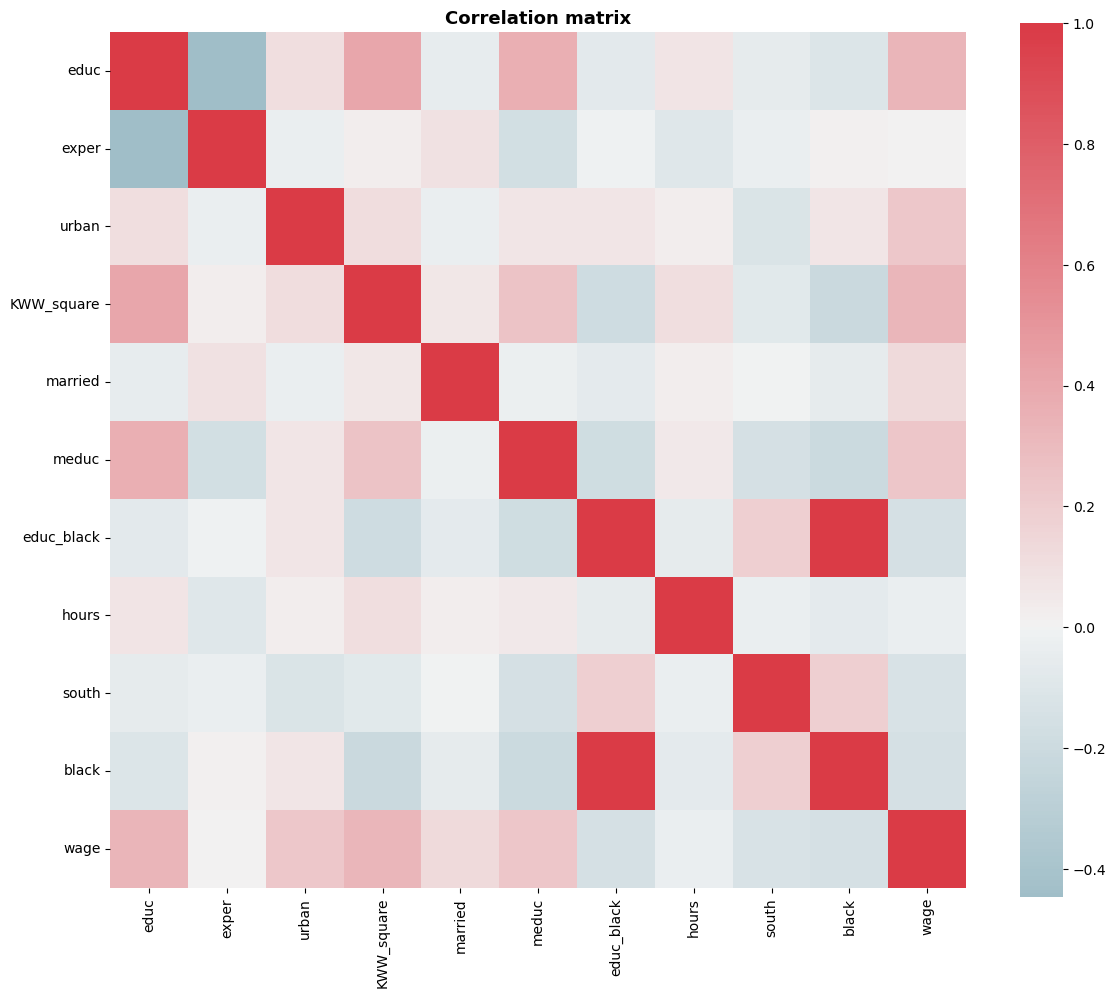

               Model        RMSE         MAD  Forecast R^2
0  Linear Regression  337.799166  257.914251      0.182032


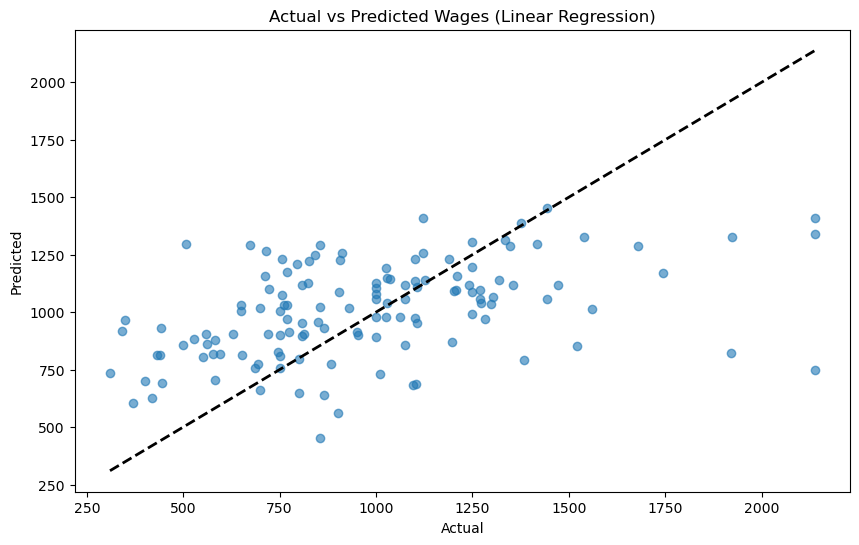

In [222]:
# Model 11

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

train['exper_age'] = train['exper'] * train['age']
train['educ_black'] = train['educ'] * train['black']
test['exper_age'] = test['exper'] * test['age']
test['educ_black'] = test['educ'] * test['black']
test['IQ_square'] = test['IQ'] * test['IQ']
test['KWW_square'] = test['KWW'] * test['KWW']

data_cl['exper_age'] = data_cl['exper'] * data_cl['age']
data_cl['educ_black'] = data_cl['educ'] * data_cl['black']
data_cl['IQ_square'] = data_cl['IQ'] * data_cl['IQ']
data_cl['KWW_square'] = data_cl['KWW'] * data_cl['KWW']

# Define features and target variable
features = ['educ', 'exper', 'urban', 'KWW_square', 'married','meduc', 'educ_black','hours','south','black']
target = 'wage'

# # Drop rows with NaN values
# data = data.dropna(subset=features + [target])

# Define train and test data
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Correlation matrix visualization
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_cl[features + [target]].corr(), vmax=1, center=0, square=True, ax=ax, cmap=cmap)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
lr_pred = lr_model.predict(X_test)

# Function to calculate forecast R^2
def forecast_r2(y_true, y_pred):
    y_mean = y_true.mean()
    ss_total = ((y_true - y_mean) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    return 1 - (ss_res / ss_total)

# Calculate metrics
def evaluate_model(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mad = mean_absolute_error(y_true, y_pred)
    r2 = forecast_r2(y_true, y_pred)
    return rmse, mad, r2

lr_rmse, lr_mad, lr_r2 = evaluate_model(y_test, lr_pred)

# Summary table
summary = pd.DataFrame({
    'Model': ['Linear Regression'],
    'RMSE': [lr_rmse],
    'MAD': [lr_mad],
    'Forecast R^2': [lr_r2]
})

print(summary)

# Plotting function
def plot_predictions(y_true, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, predictions, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Wages ({model_name})')
    plt.show()

# Generate plot for Linear Regression
plot_predictions(y_test, lr_pred, 'Linear Regression')

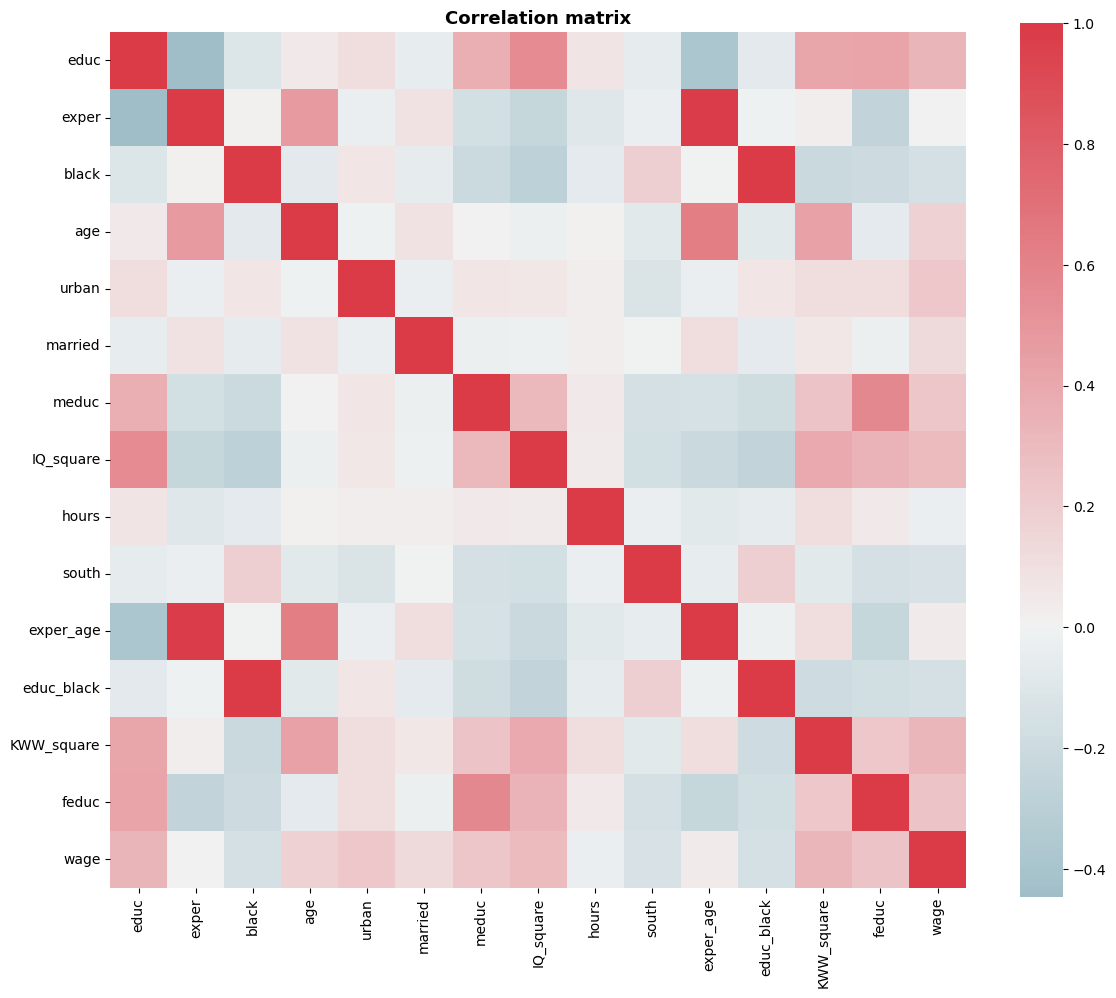

               Model        RMSE         MAD  Forecast R^2
0  Linear Regression  334.704233  254.192172      0.196952


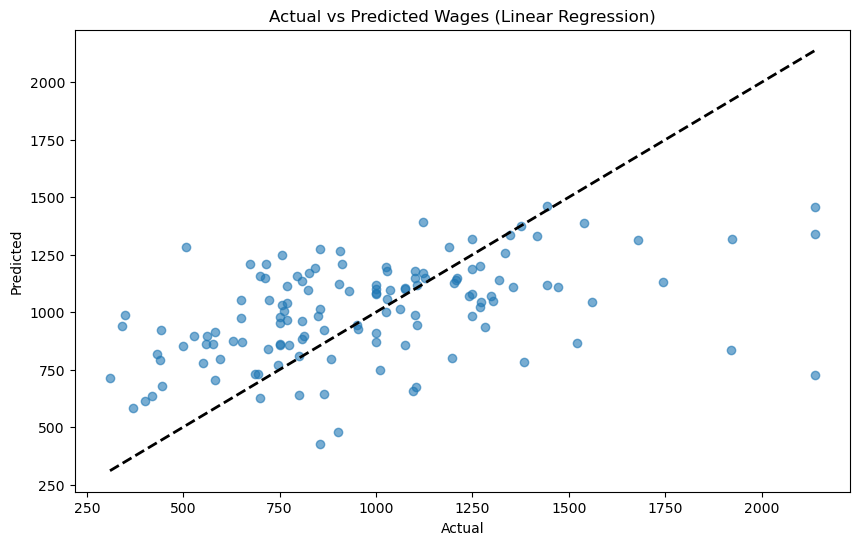

In [223]:
# Model 10

# Define features and target variable
features = ['educ', 'exper', 'black','age','urban','married','meduc','IQ_square','hours','south','exper_age','educ_black','KWW_square','feduc']
target = 'wage'

# # Drop rows with NaN values
# data = data.dropna(subset=features + [target])

# Define train and test data
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Correlation matrix visualization
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_cl[features + [target]].corr(), vmax=1, center=0, square=True, ax=ax, cmap=cmap)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
lr_pred = lr_model.predict(X_test)

# Function to calculate forecast R^2
def forecast_r2(y_true, y_pred):
    y_mean = y_true.mean()
    ss_total = ((y_true - y_mean) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    return 1 - (ss_res / ss_total)

# Calculate metrics
def evaluate_model(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mad = mean_absolute_error(y_true, y_pred)
    r2 = forecast_r2(y_true, y_pred)
    return rmse, mad, r2

lr_rmse, lr_mad, lr_r2 = evaluate_model(y_test, lr_pred)

# Summary table
summary = pd.DataFrame({
    'Model': ['Linear Regression'],
    'RMSE': [lr_rmse],
    'MAD': [lr_mad],
    'Forecast R^2': [lr_r2]
})

print(summary)

# Plotting function
def plot_predictions(y_true, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, predictions, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Wages ({model_name})')
    plt.show()

# Generate plot for Linear Regression
plot_predictions(y_test, lr_pred, 'Linear Regression')

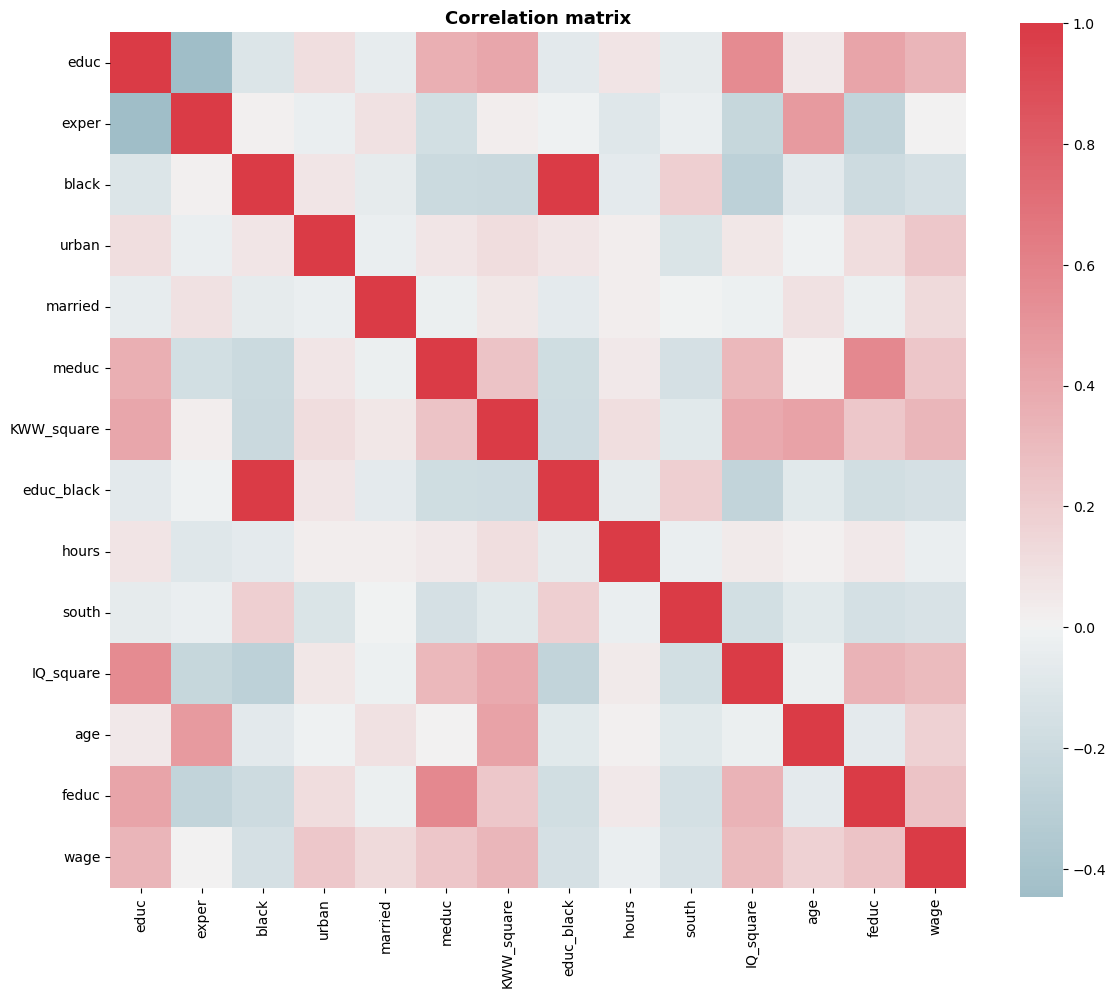

               Model        RMSE         MAD  Forecast R^2
0  Linear Regression  331.759785  254.000015      0.211019


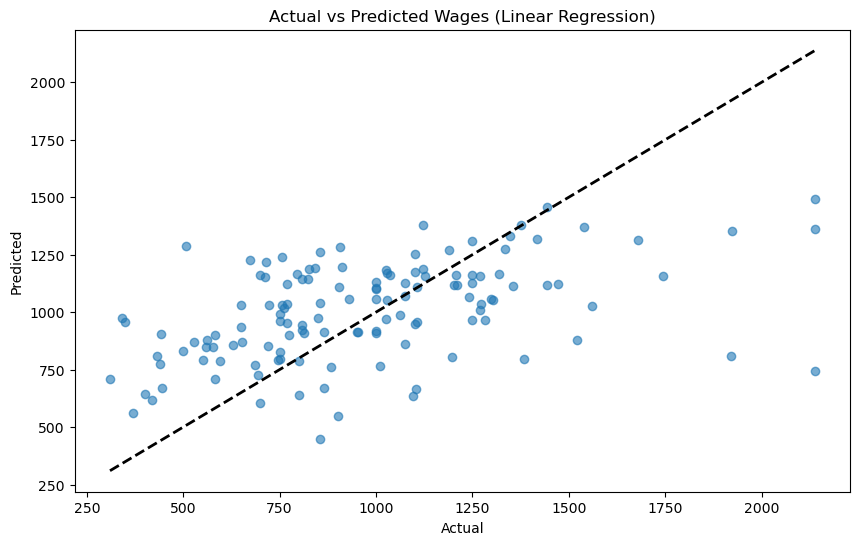

In [224]:
# Model 9

# Define features and target variable
features = ['educ', 'exper', 'black', 'urban', 'married', 'meduc', 'KWW_square','educ_black','hours','south','IQ_square','age','feduc']
target = 'wage'

# # Drop rows with NaN values
# data = data.dropna(subset=features + [target])

# Define train and test data
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Correlation matrix visualization
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_cl[features + [target]].corr(), vmax=1, center=0, square=True, ax=ax, cmap=cmap)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
lr_pred = lr_model.predict(X_test)

# Function to calculate forecast R^2
def forecast_r2(y_true, y_pred):
    y_mean = y_true.mean()
    ss_total = ((y_true - y_mean) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    return 1 - (ss_res / ss_total)

# Calculate metrics
def evaluate_model(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mad = mean_absolute_error(y_true, y_pred)
    r2 = forecast_r2(y_true, y_pred)
    return rmse, mad, r2

lr_rmse, lr_mad, lr_r2 = evaluate_model(y_test, lr_pred)

# Summary table
summary = pd.DataFrame({
    'Model': ['Linear Regression'],
    'RMSE': [lr_rmse],
    'MAD': [lr_mad],
    'Forecast R^2': [lr_r2]
})

print(summary)

# Plotting function
def plot_predictions(y_true, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, predictions, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Wages ({model_name})')
    plt.show()

# Generate plot for Linear Regression
plot_predictions(y_test, lr_pred, 'Linear Regression')

#### Accuracy of Predictions
A table summarising the test sample predictions from each model follows:

| Model                 |   RMSE   |    MAD   | Forecast $R^2$ |  
|-----------------------|----------|----------|----------------|
| 9                     |  331.760 |  254.000 |     0.211      |
|10                     |  334.704 |  254.192 |     0.197      |
|11                     |  337.799 |  257.914 |     0.182      |

The analysis of wage prediction models reveal a detailed understanding of the factors influencing wages.The employed three distinct models with RMSE values of 331.760, 334.704, and 337.799 indicate their varying predictive accuracy. The model with the lowest RMSEt suggests a slightly better fit compared to the others implying it has the highest precision in wage prediction among the tested models. The inclusion of the interaction term Education and Black in the best performing model underscores the influence of considering how different factors interplay to affect wages. Our models reveal forecast R squared values of 0.211 , 0.197, 0.182. These metrics signify the proportion of variance in the test data that our models can explain serving as indicators of predictive performance. While these factors capture a portion of the wage variability there remains considerable unexplained variance suggesting the influence of other unobserved factors. The model with the highest forecast r squared of 0.211 (model 9) outperforms the others indicating superior predictive capabilities. In terms of the MAD values provided a lower MAD indicated that, on average, our model's predictions deviate less from the actual wages implying higher precision in prediction. Among the models the lowest MAD 254.000 (model 9) suggests that it has the smallest average absolute error in predicting wages, making it the most accurate in this regard.

***

## IX. Conclusion

Initally, we proposed Model 11 as the optimal model, however, based on the forecast prediction, Model 9 with 13 variables actually gives us a better forecast. However, it's important to note that the $R^2$ of Model 9 is only 21.1%, this indicates that the model won't give a highly accurate prediction of the wage.

As we navigate the complex landscape of workforce development, our analysis aimed to shed light on the factors influencing job prospects and potential strategies to enhance employability. Through a series of regression analyses, we observed the impact of education and job experience on wages, providing insights that are critical for shaping policy decisions.

Our findings reveal that both education and job experience play pivotal roles in determining job prospects and subsequent wages. Investing in increasing the average years of education can indeed lead to higher wages, reflecting the importance of educational attainment in today's competitive job market. However, our analysis also underscores the significance of job experience, suggesting that improvements in this area can significantly enhance job prospects and contribute to better wage outcomes.

If the Departments were to prioritise one over the other, the likely outcome would depend on the specific context and needs of the target population. Prioritising investments in increasing average years of education could lead to a more skilled workforce overall, potentially resulting in higher wages and better job opportunities for individuals. On the other hand, focusing solely on improving early job experience might lead to a more immediate impact on job placement and skill development tailored to the needs of specific industries. However, our analysis suggests that a balanced approach that incorporates both education and early job experience is optimal for achieving sustainable improvements in job prospects and wage outcomes.

Looking ahead, future studies should continue to explore the complex interplay between education, job experience, and wage outcomes. Studies tracking individuals over time can provide valuable insights into the long-term effects of different interventions on career trajectories and economic mobility. Moreover, research that examines the role of soft skills, such as communication and problem-solving abilities, in conjunction with technical skills can further inform strategies for enhancing job readiness and success in the workforce.

In conclusion, by adopting a multifaceted approach that prioritises investments in education and job experience, the Departments of Education and Labor can foster an environment conducive to improved job prospects and economic prosperity for all. Together, we can empower individuals to achieve their full potential and contribute meaningfully to the workforce and society at large.